# Titanic New Version

### Import Cell

In [1]:
!conda info --envs

# conda environments:
#
base                     C:\ProgramData\anaconda3
aiml                  *  C:\ProgramData\anaconda3\envs\aiml
crisis                   C:\ProgramData\anaconda3\envs\crisis
highres                  C:\ProgramData\anaconda3\envs\highres



In [2]:
# Cell magic for visualization
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn as skl

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Optimization
import optuna

# Interpretation
import shap
shap.initjs()

### Import training Dataset

In [3]:
train  = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

In [4]:
# Initial checks
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
X_Pred_Passenger = test['PassengerId']

## Exploratory Data Analysis

In [6]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [7]:
train["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [8]:
# Seperate the features
numerical_features = train.select_dtypes(include=['number'])
numerical_features = numerical_features.drop(columns=['Survived','PassengerId','Pclass'])
categorical_features = train.select_dtypes(exclude=['number'])
categorical_features_pred = test.select_dtypes(exclude=['number'])
# categorical_features_pred = categorical_features_pred.to_frame()
categorical_features["Pclass"] = train["Pclass"]
categorical_features_pred["Pclass"] = test["Pclass"]
categorical_features = categorical_features.drop(columns=['Name','Ticket'])
categorical_features_pred = categorical_features_pred.drop(columns=['Name','Ticket'])
target_column = "Survived"

### Numerical Data Heatmap Feature Correlations

In [9]:
def heatmap(numerical_features) :
    plt.figure(figsize=(10, 8))
    correlation_matrix = numerical_features.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

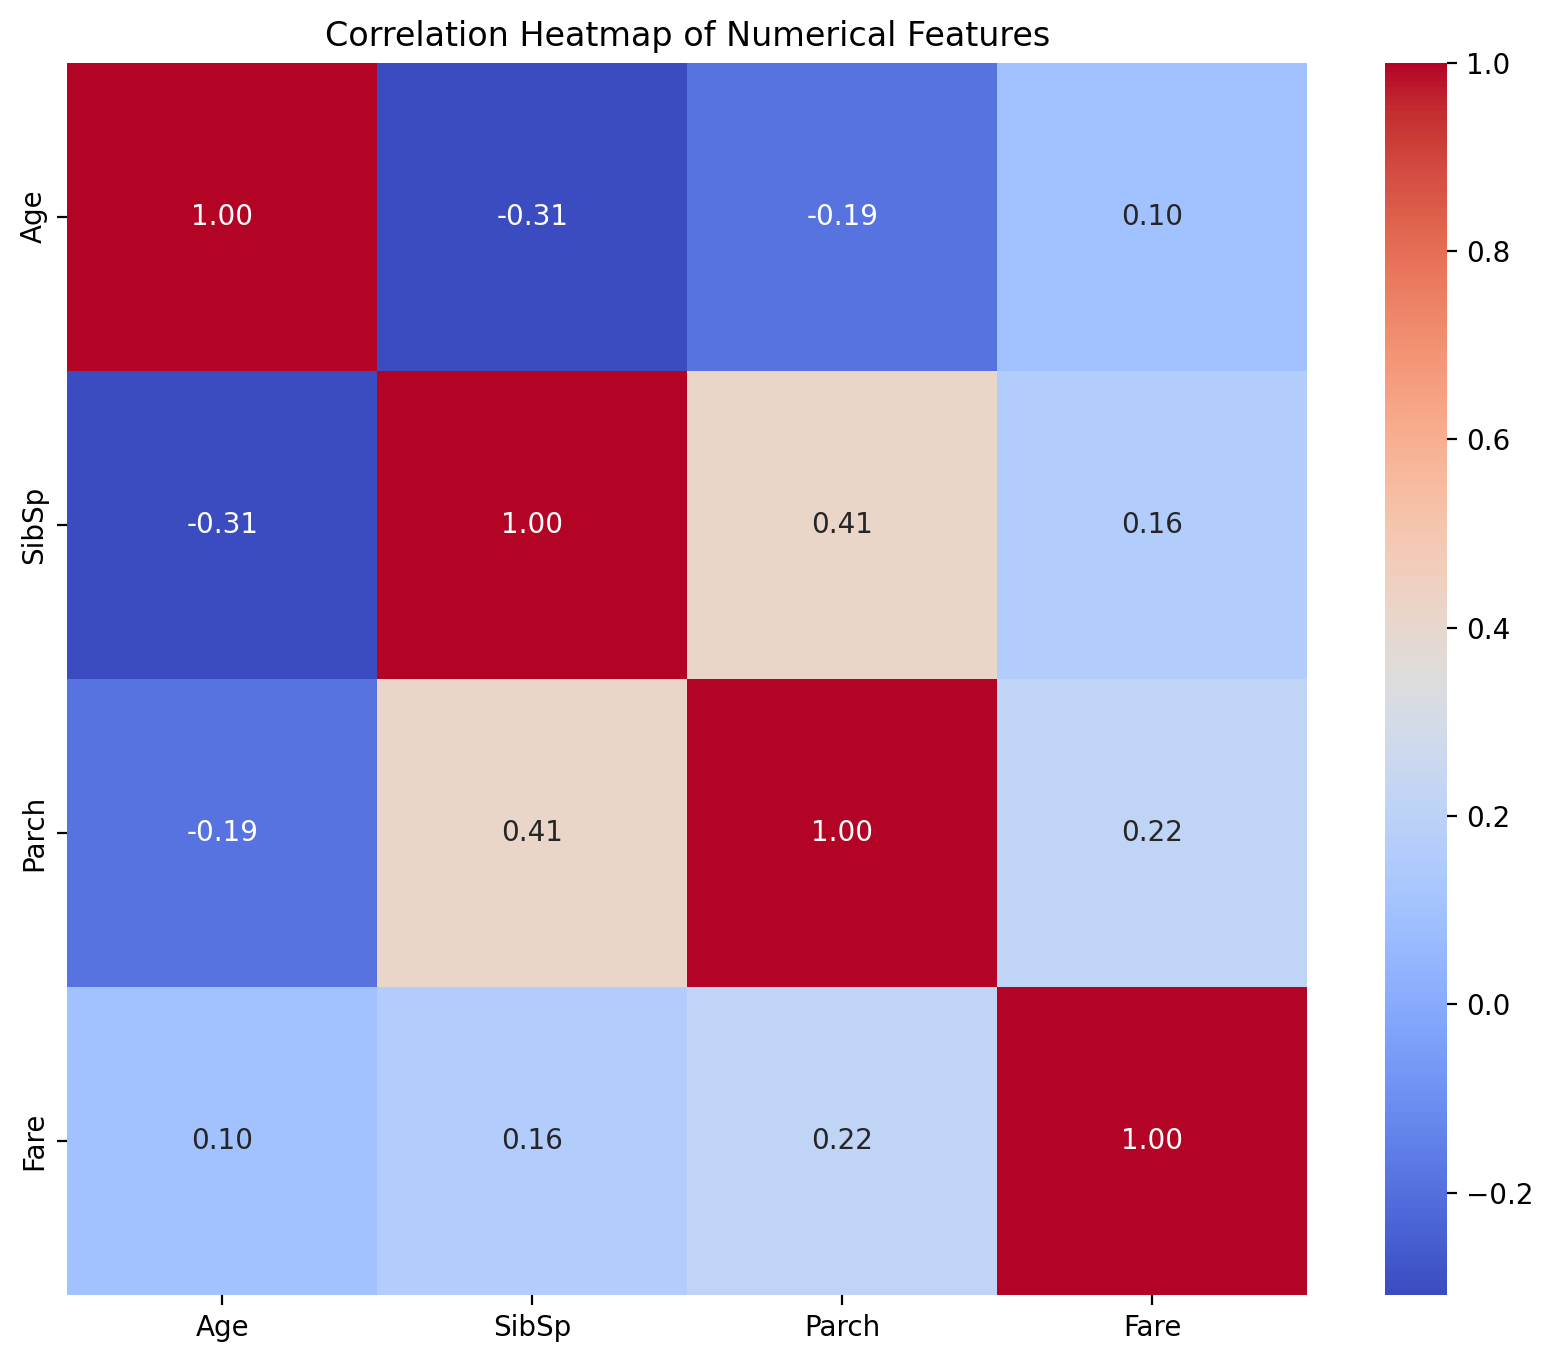

In [10]:
heatmap(numerical_features)

### Bar Plots of Numerical Features vs. Target Variable

In [11]:
def bar_plots_numerical_features(train, numerical_features, target_column) :
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.barplot(data=train, x=target_column, y=feature)
        plt.title(f'Mean {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Not Survived', 'Survived']) # Assuming 0 and 1 are your target labels
        plt.show()

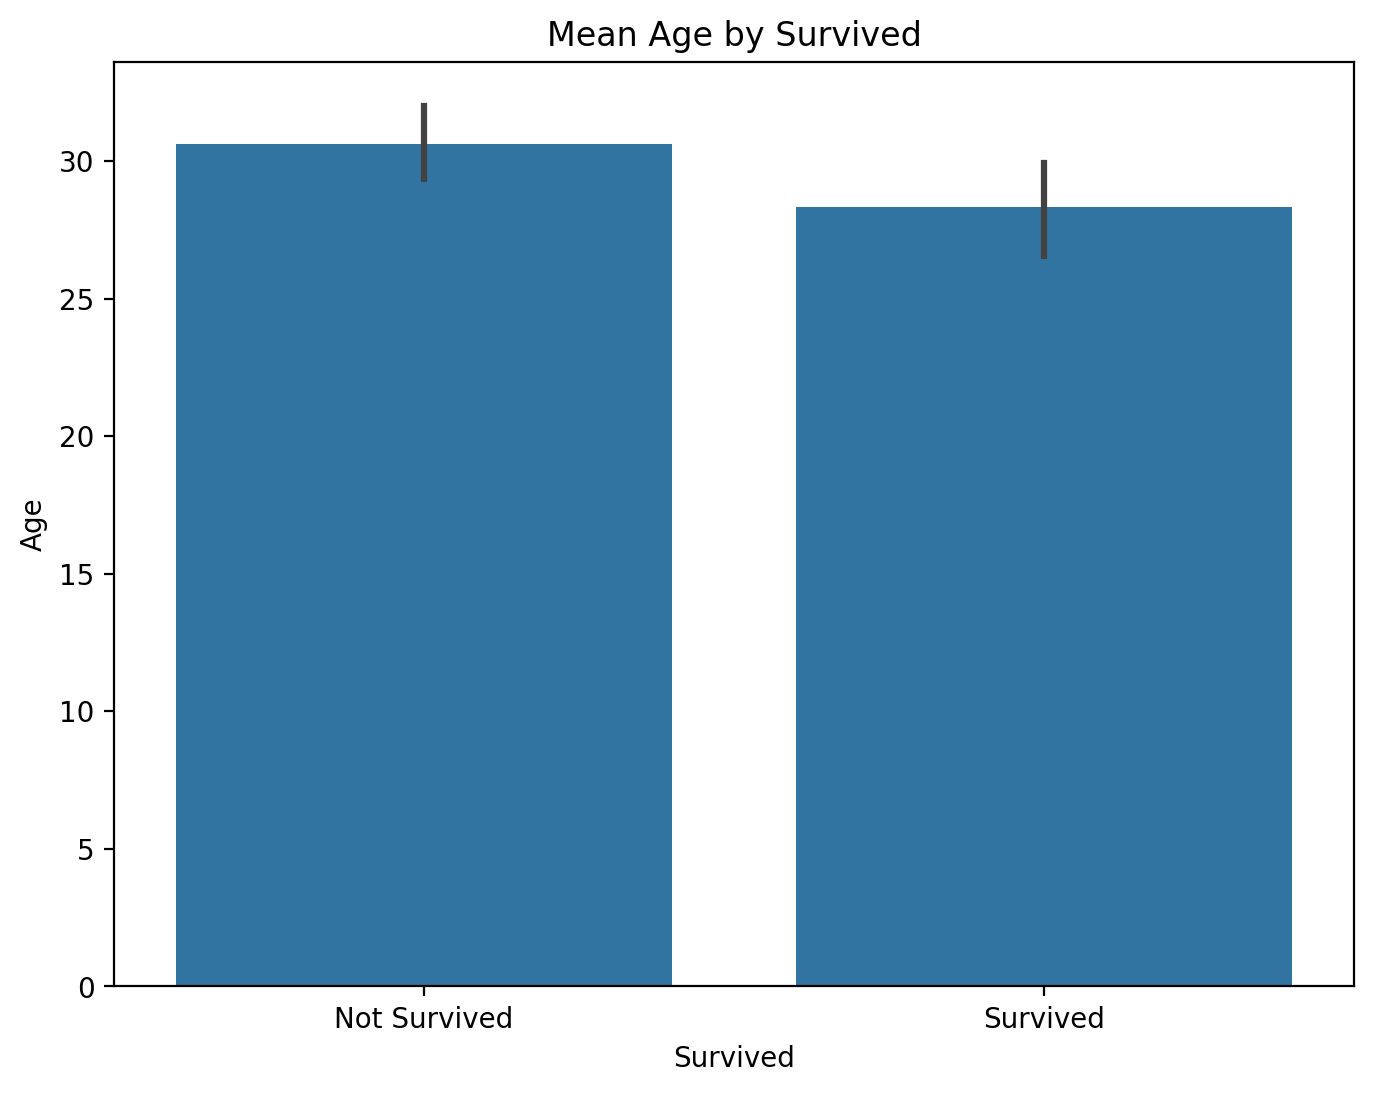

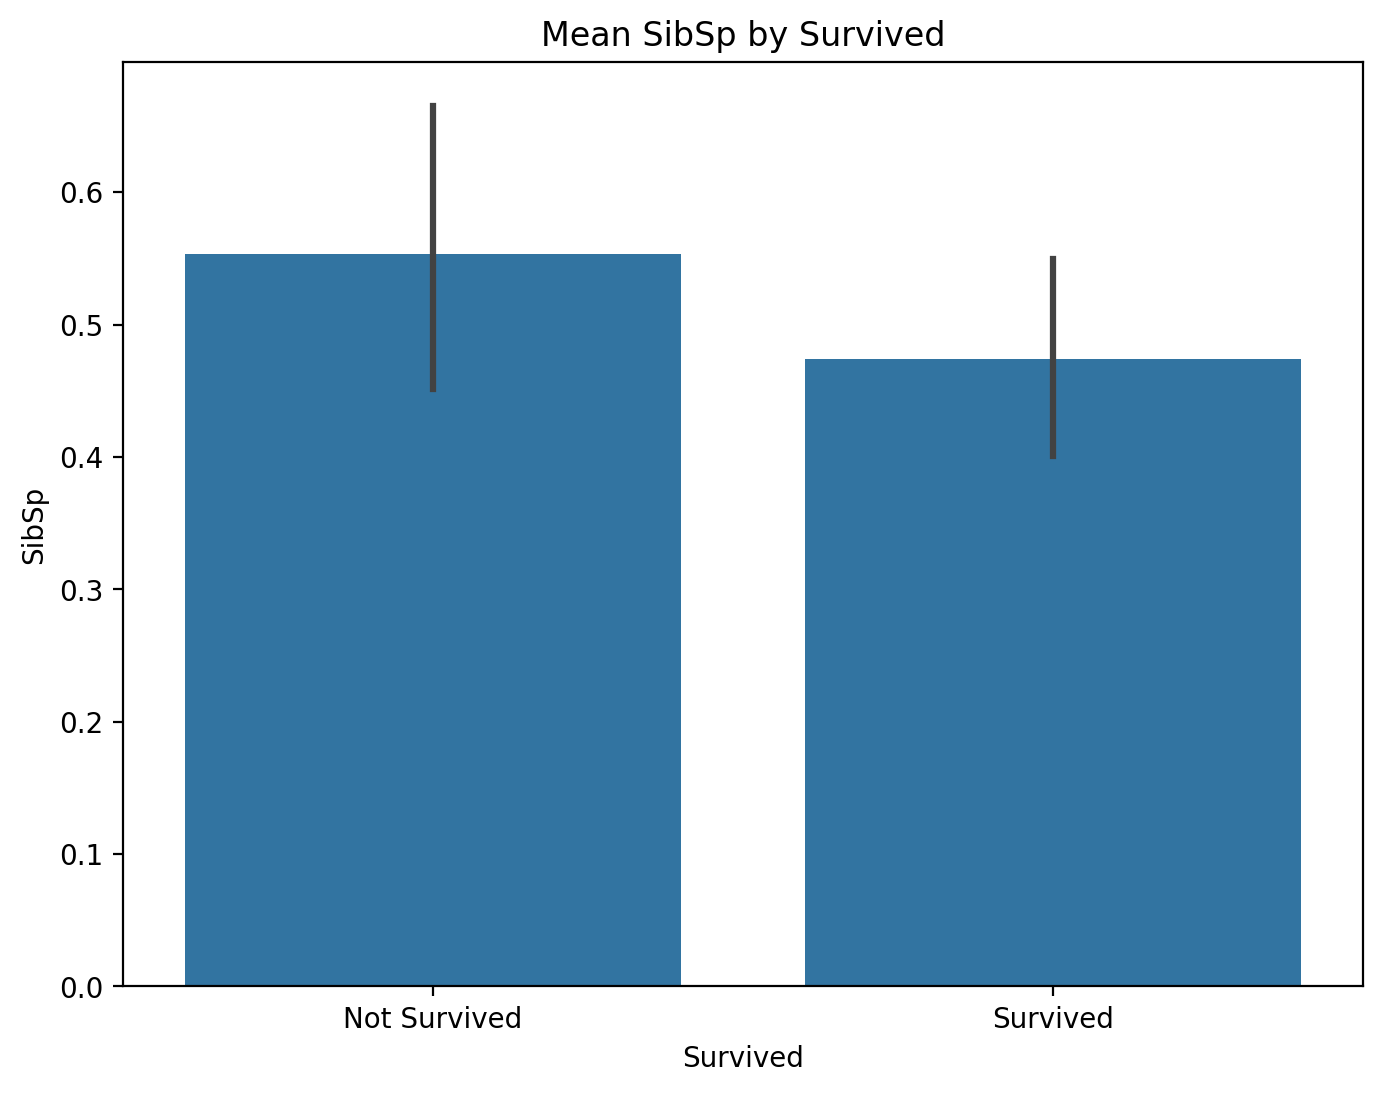

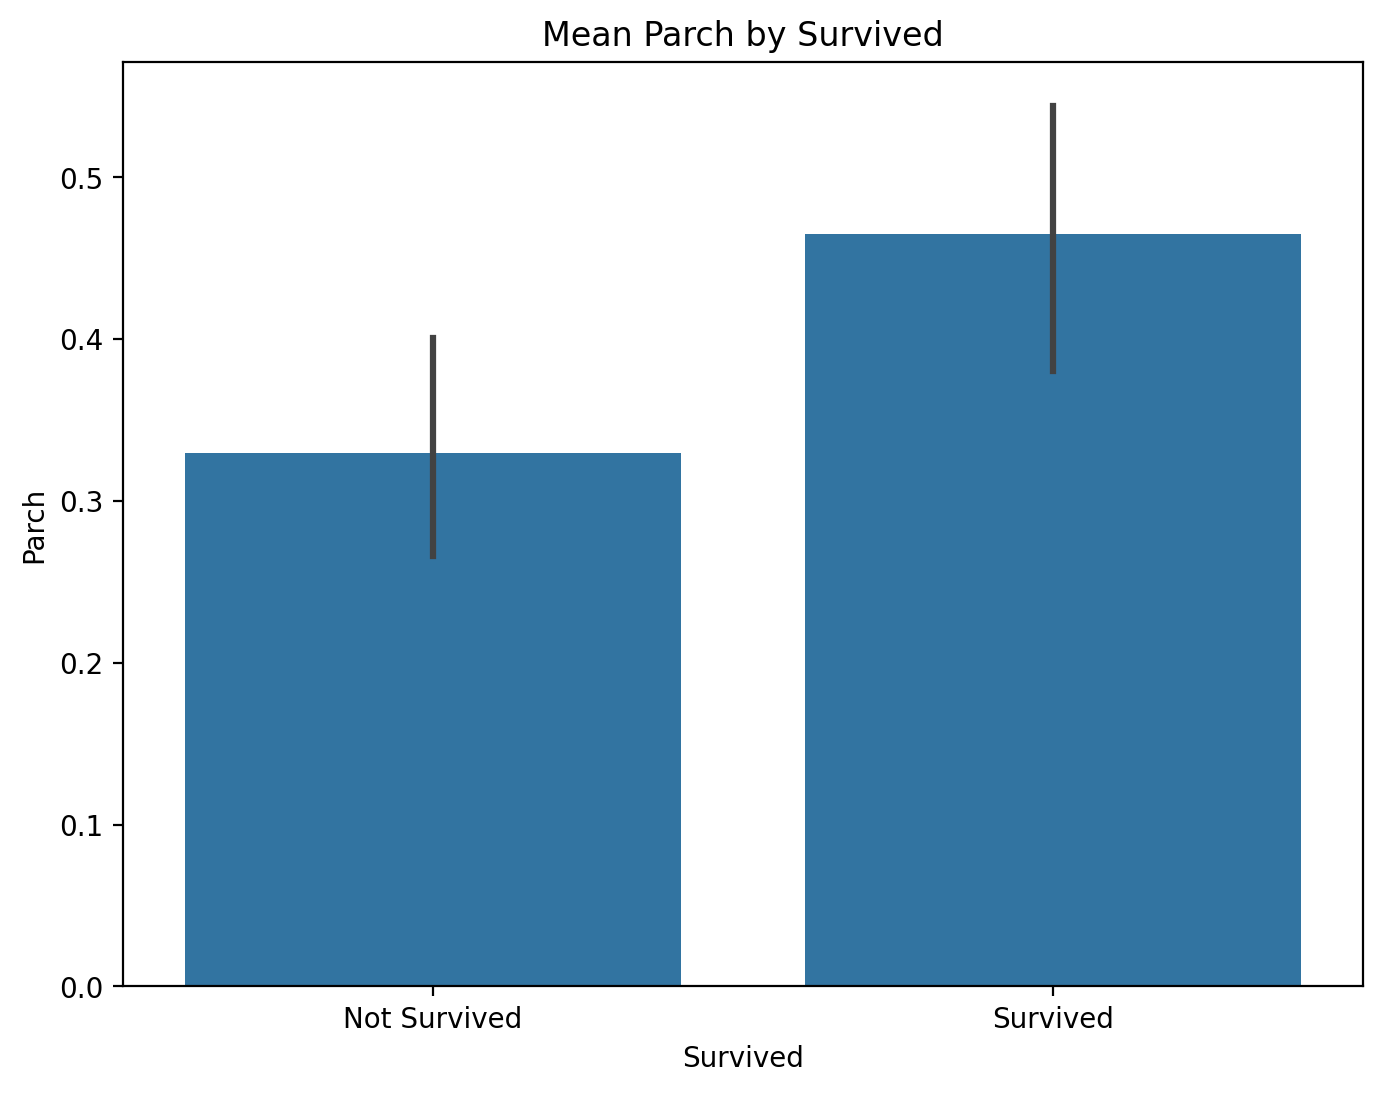

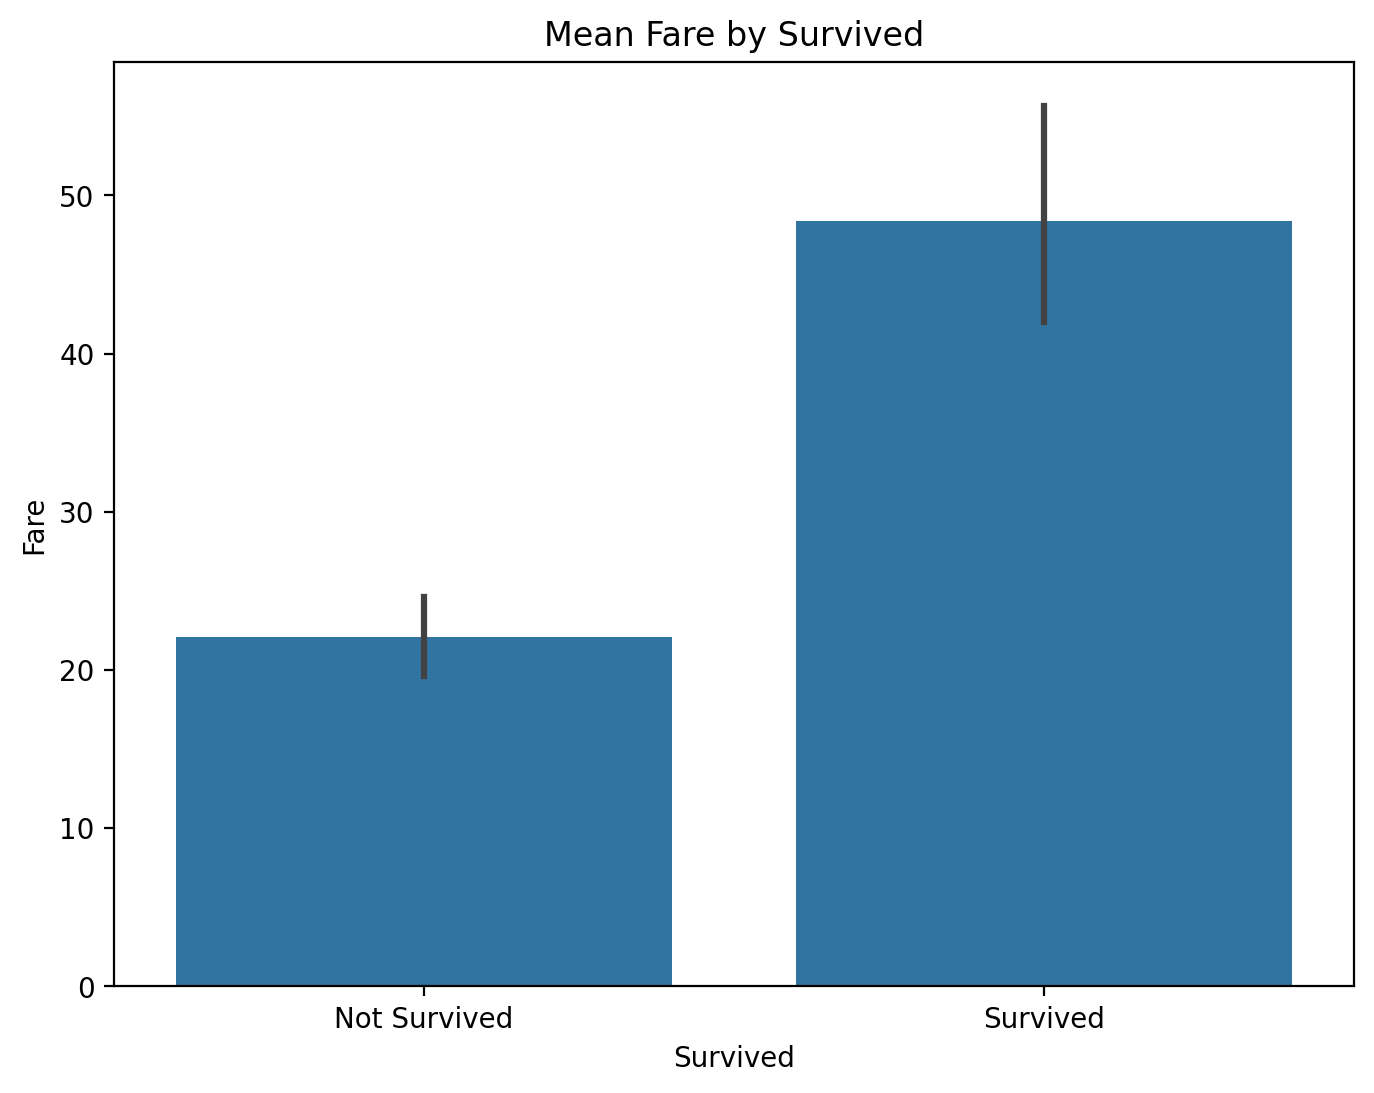

In [12]:
bar_plots_numerical_features(train, numerical_features, target_column)

### Bar Plots of Median Numerical Features vs. Target Variable

In [13]:
def bar_plots_numerical_features_median(train, numerical_features, target_column):
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.barplot(data=train, x=target_column, y=feature, estimator=np.median)
        plt.title(f'Median {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Negative Class', 'Positive Class'])
        plt.show()

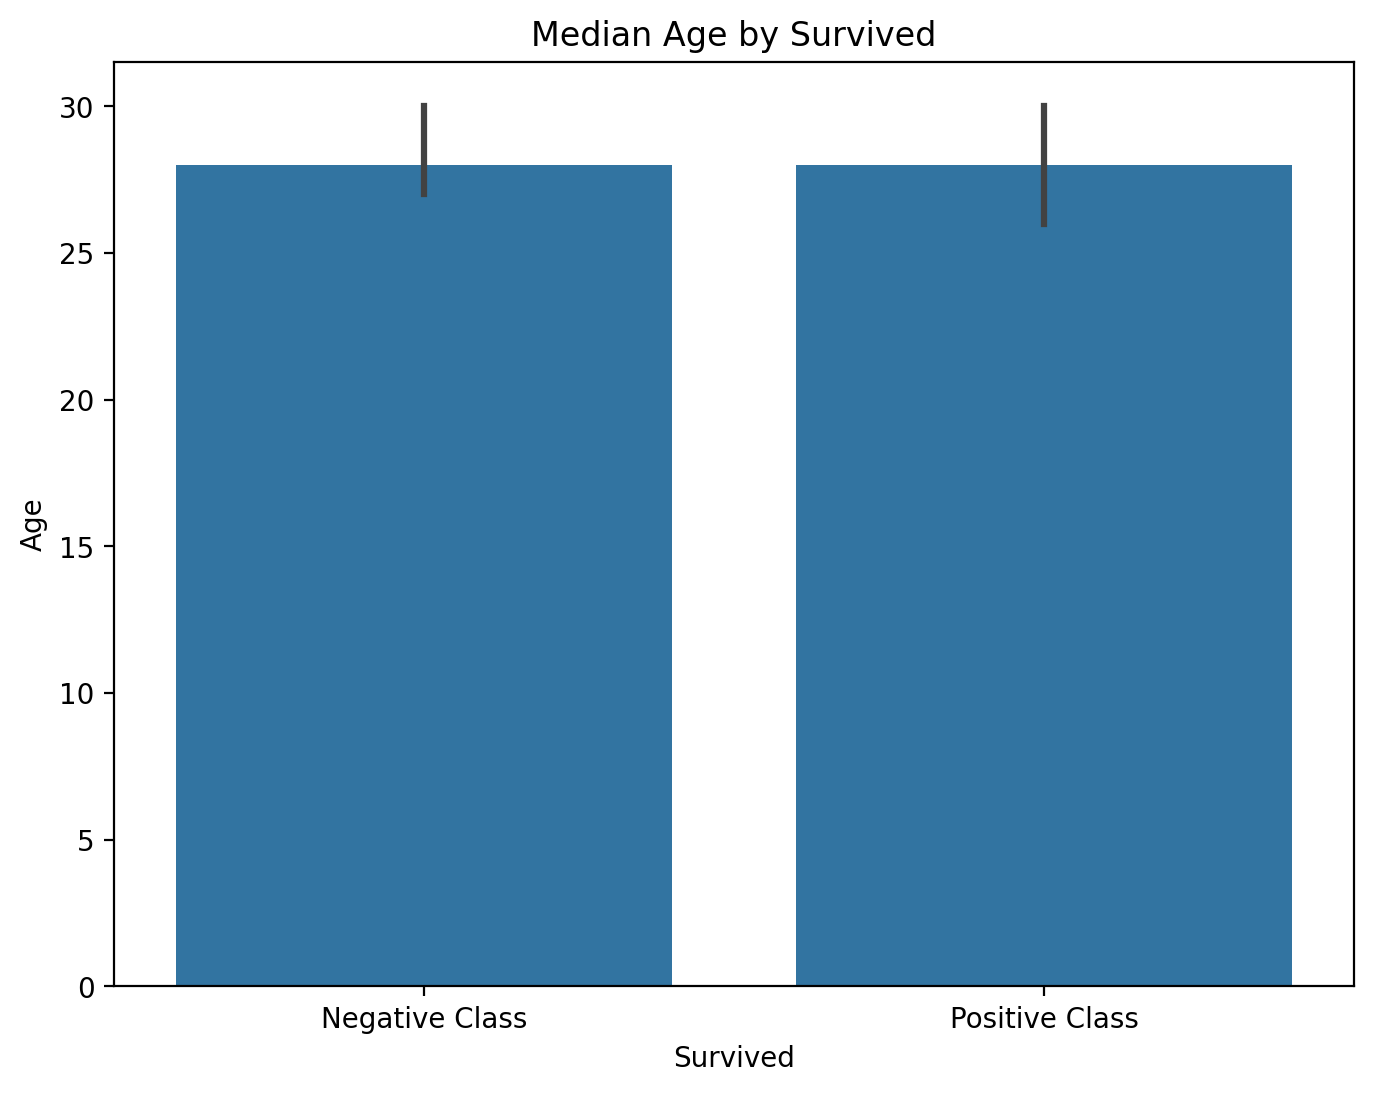

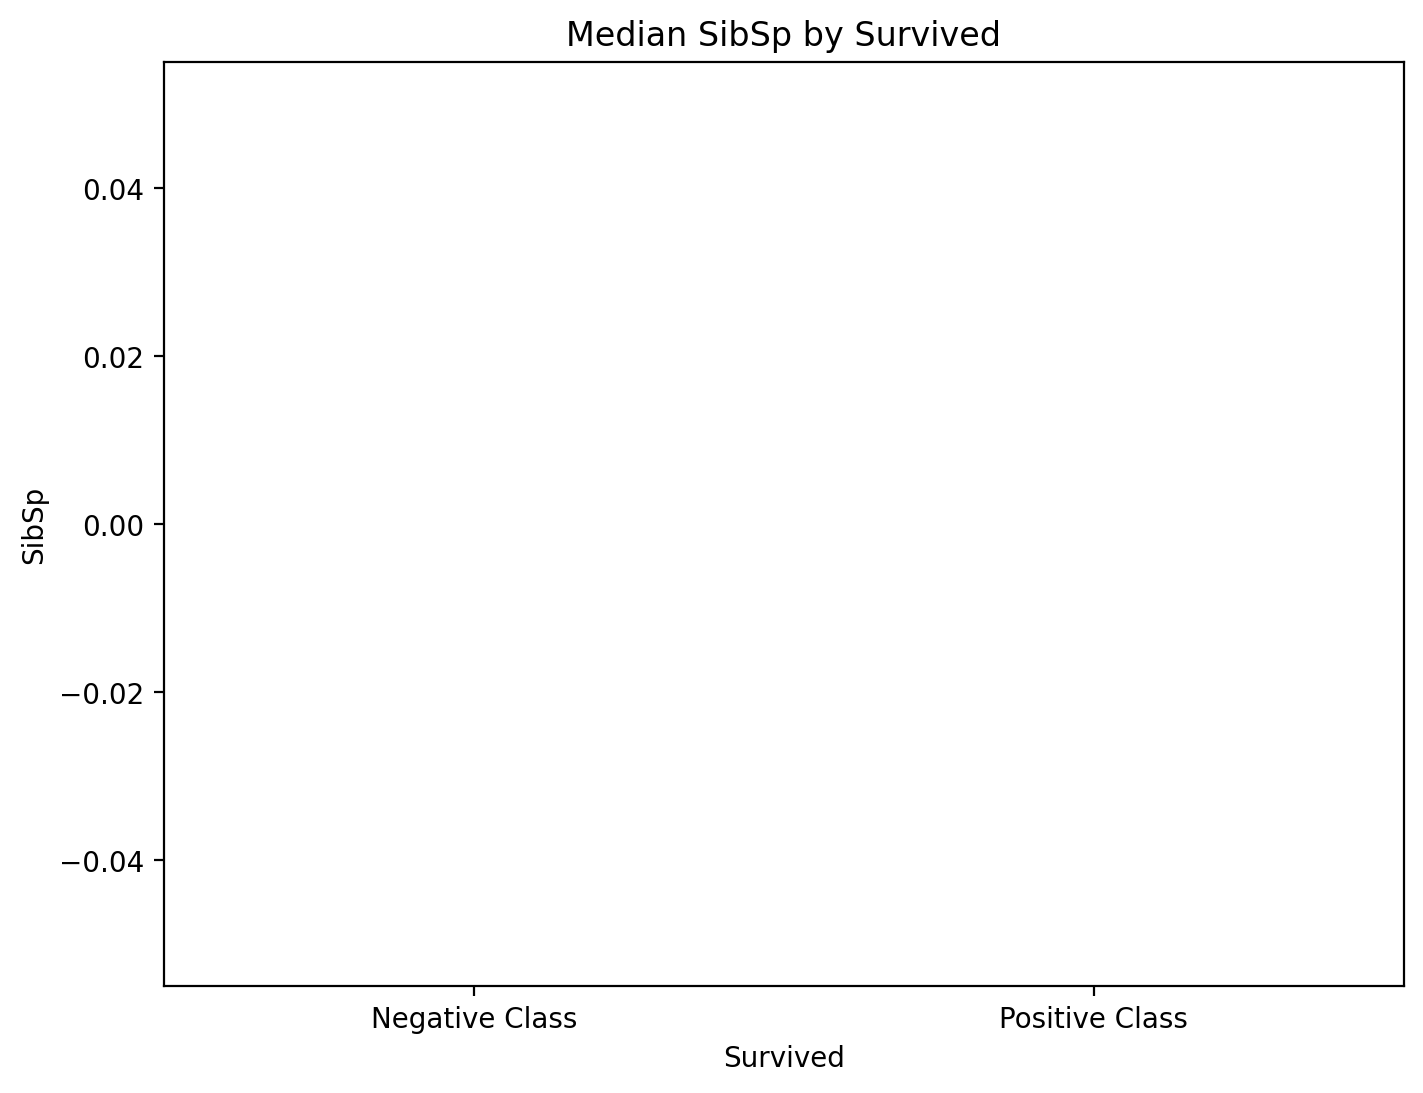

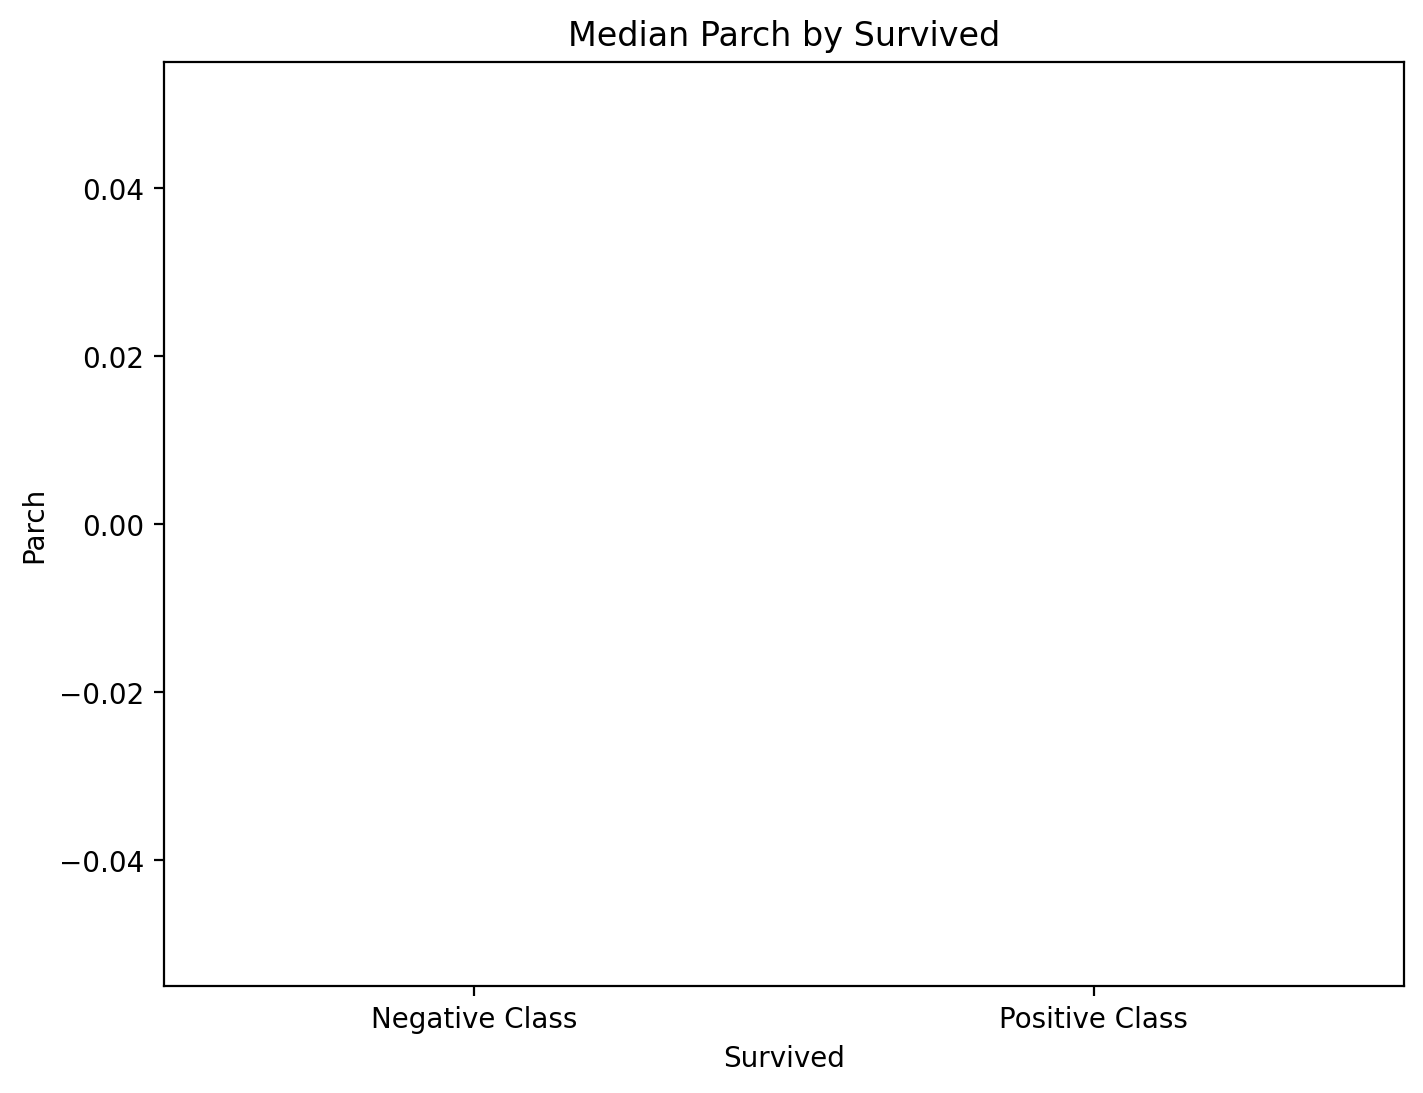

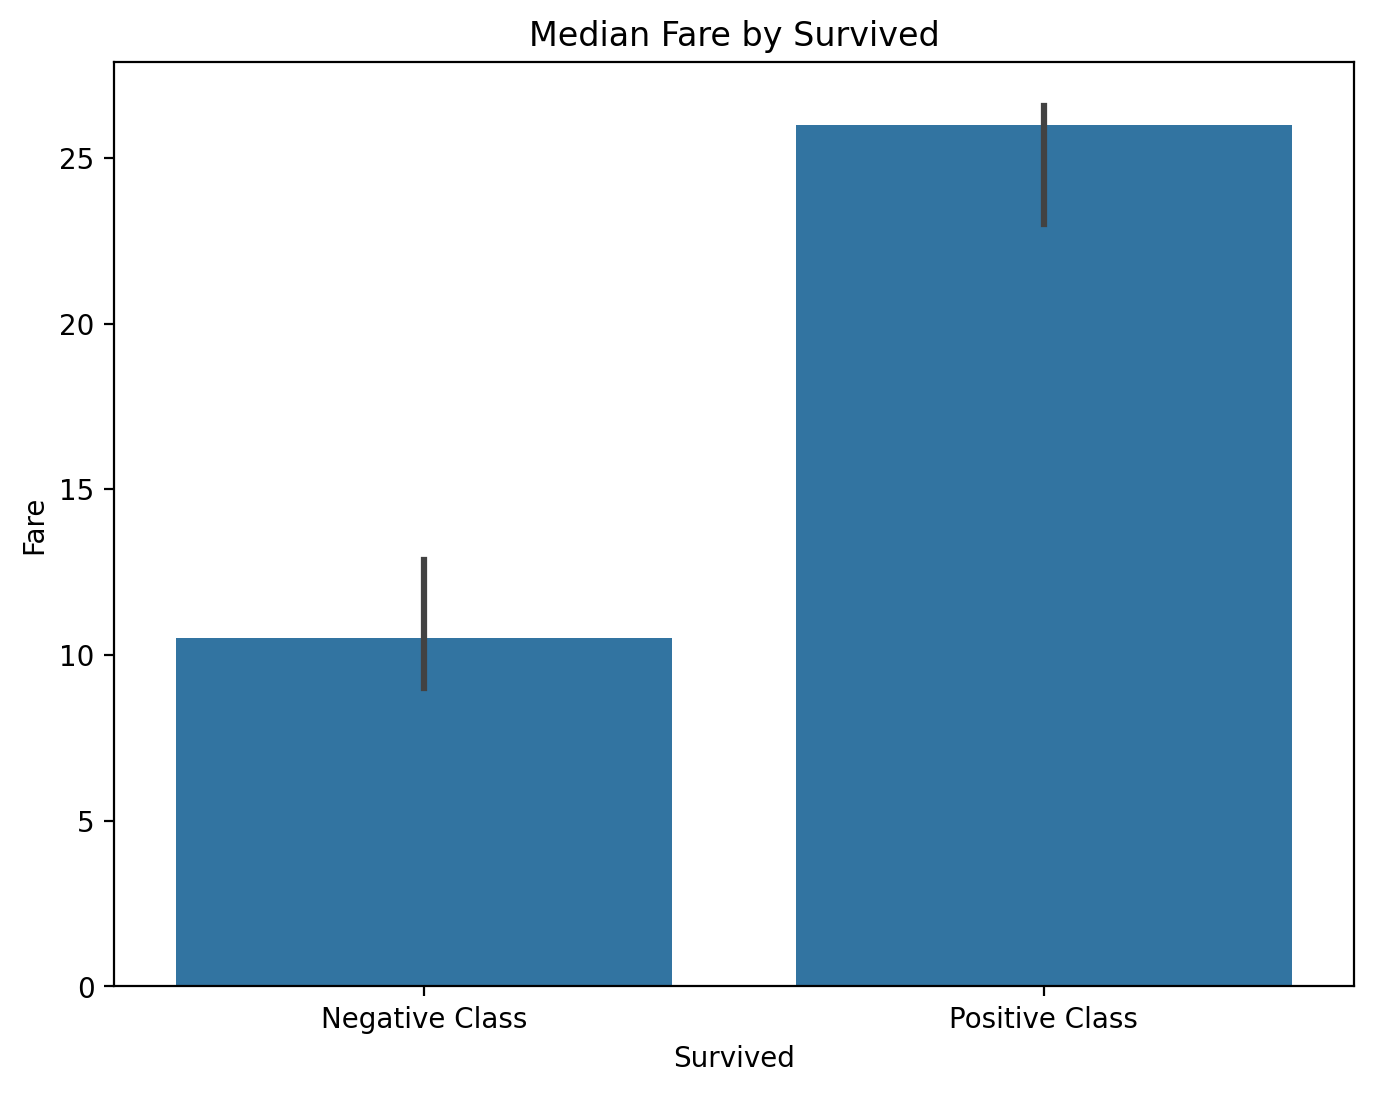

In [14]:
bar_plots_numerical_features_median(train, numerical_features, target_column)

### Distribution of Numeric Features with Histograms

In [15]:
def histograms(train, numerical_features, target_column) :
    print("\n--- Histograms of Numeric Features ---")
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=train, x=feature, hue=target_column, kde=False, multiple="stack")
        plt.title(f'Histogram of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend(title=target_column, labels=['No', 'Yes']) # Assuming 0 is 'No', 1 is 'Yes'
        plt.show()


--- Histograms of Numeric Features ---


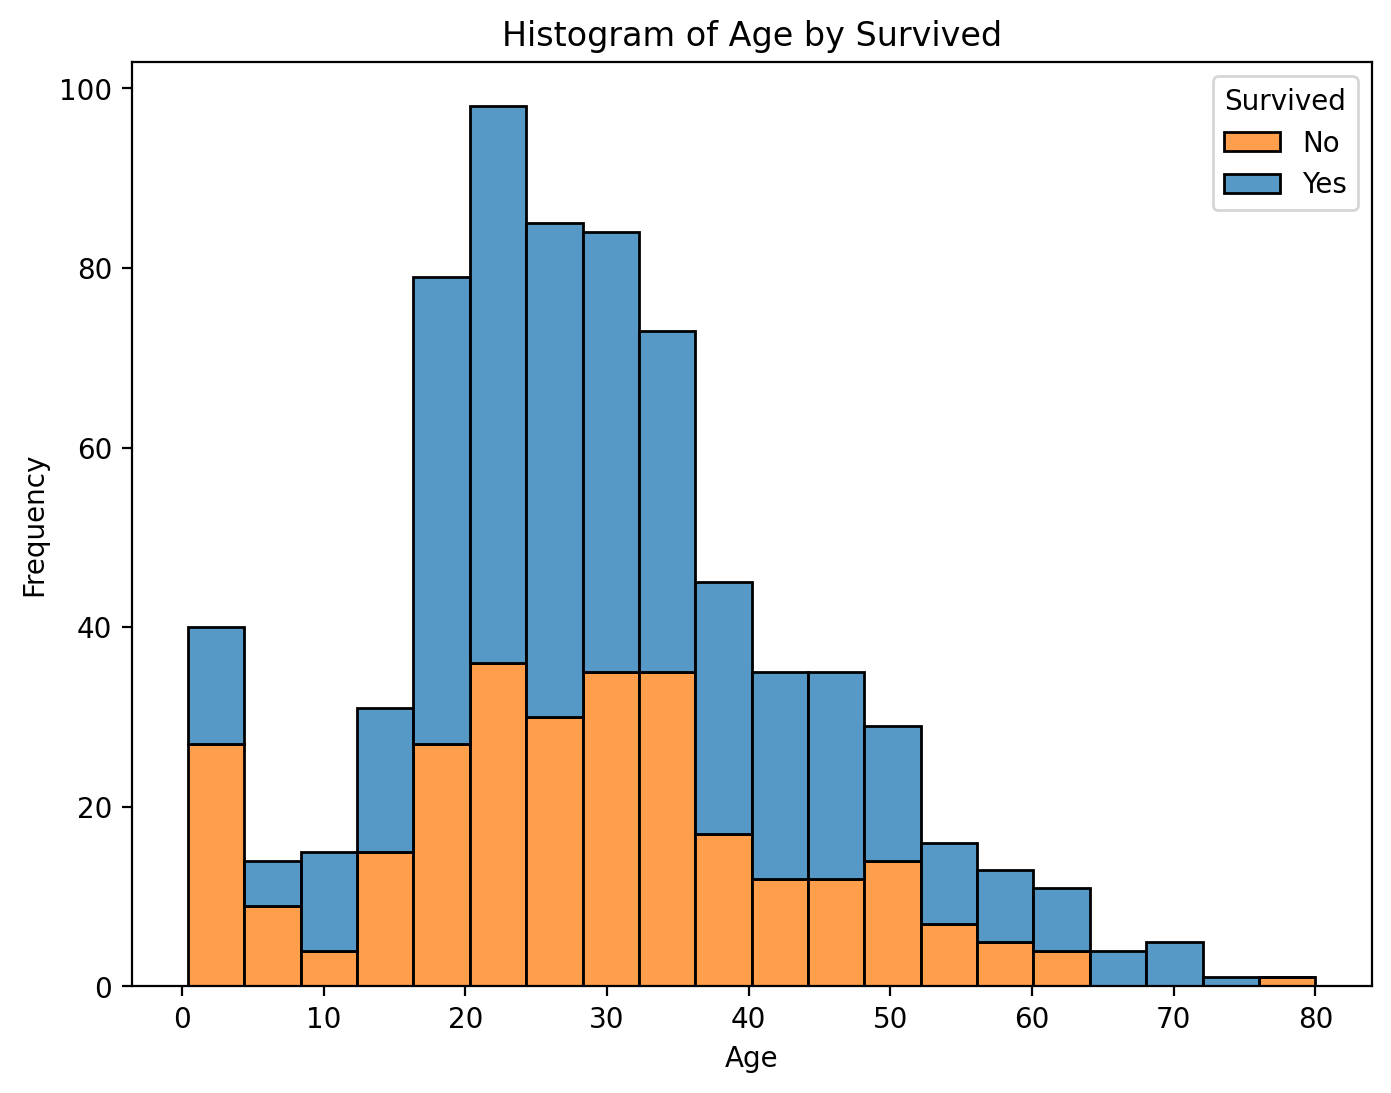

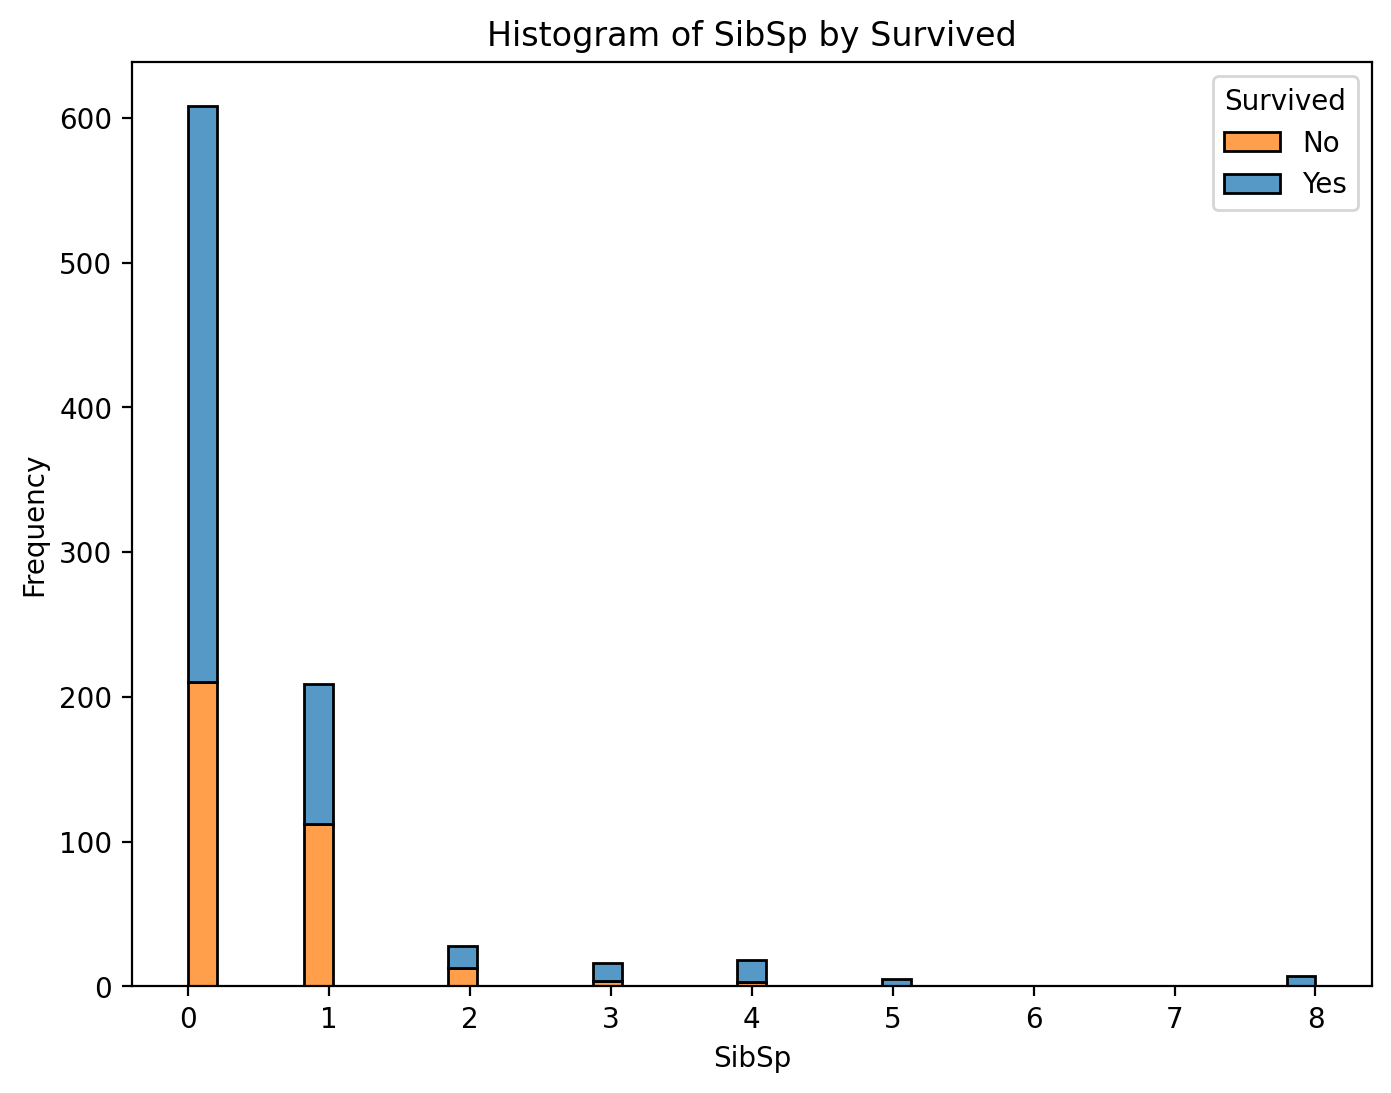

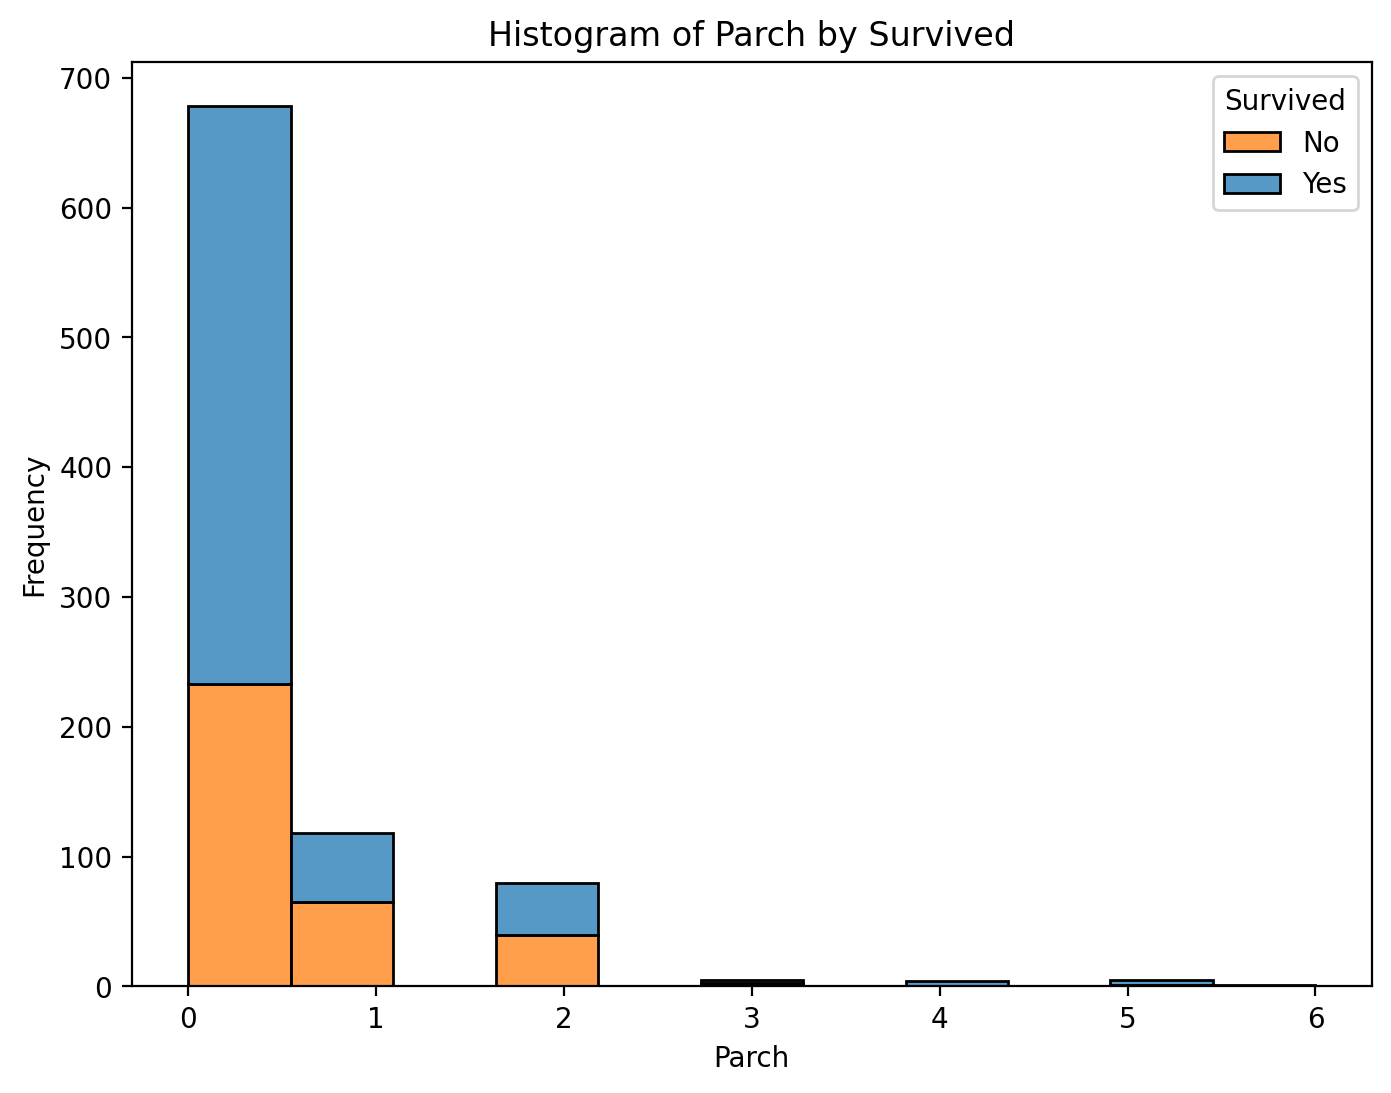

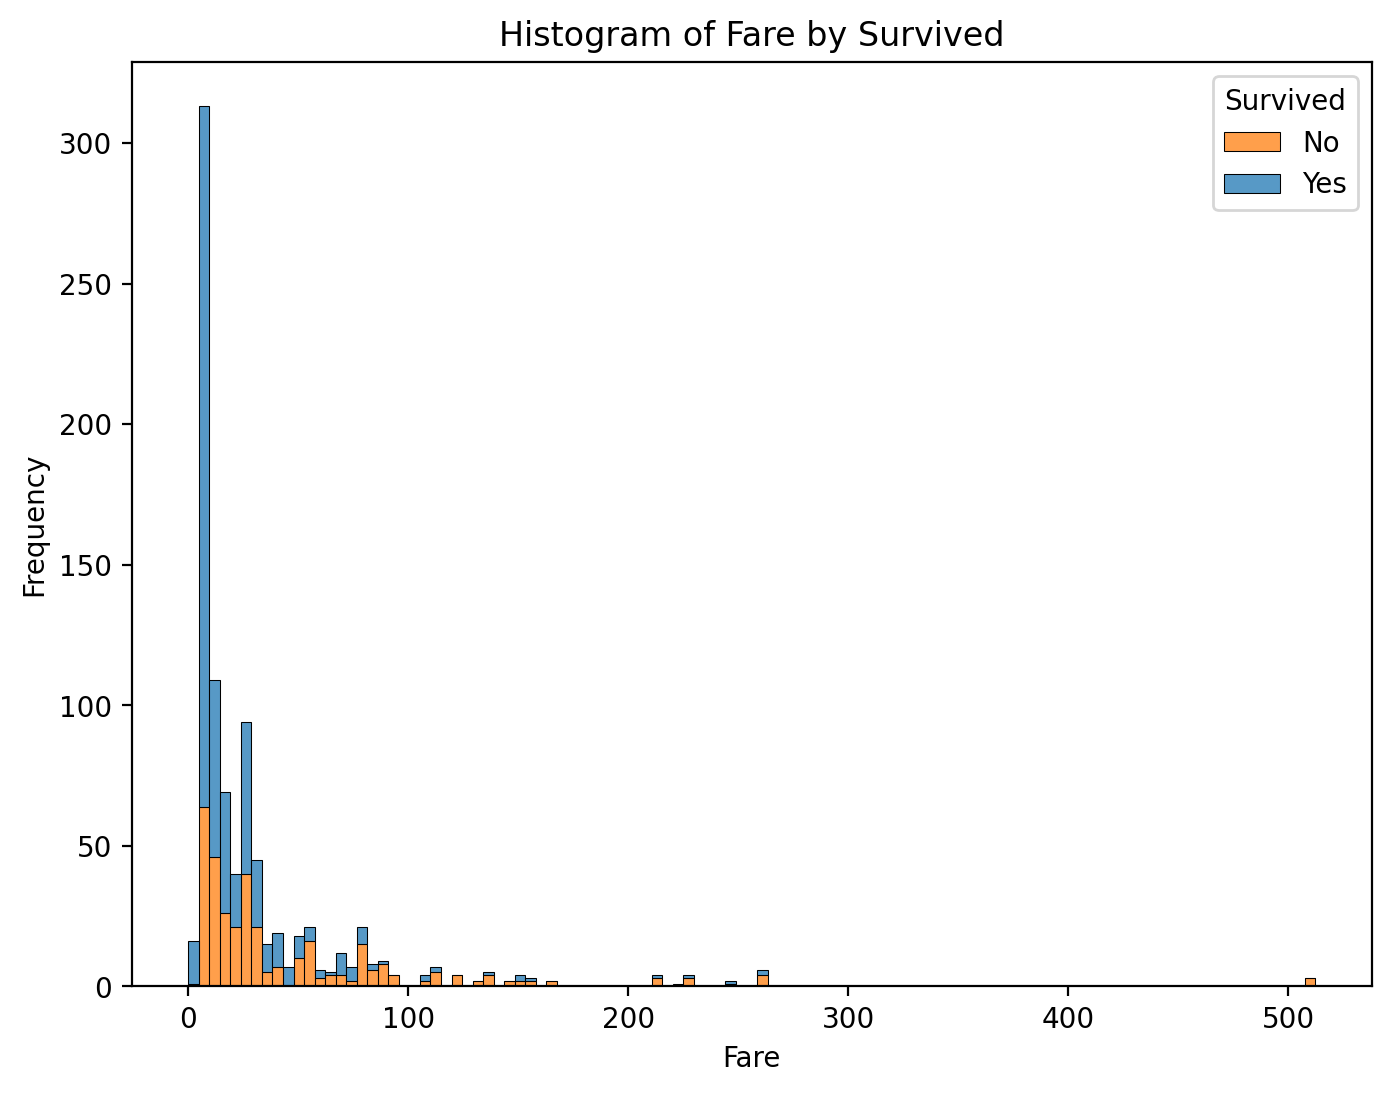

In [16]:
histograms(train, numerical_features, target_column)

### Distribution of Numeric Features with KDE Plots

In [17]:
def kde_plots(train, numerical_features, target_column) :
    print("\n--- KDE Plots of Numeric Features ---")
    for feature in numerical_features:
        plt.figure(figsize=(7, 5))
        sns.kdeplot(data=train, x=feature, hue=target_column, fill=True, alpha=.5, multiple="stack")
        plt.title(f'KDE Plot of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend(title=target_column, labels=['No', 'Yes']) # Assuming 0 is 'No', 1 is 'Yes'
        plt.show()


--- KDE Plots of Numeric Features ---


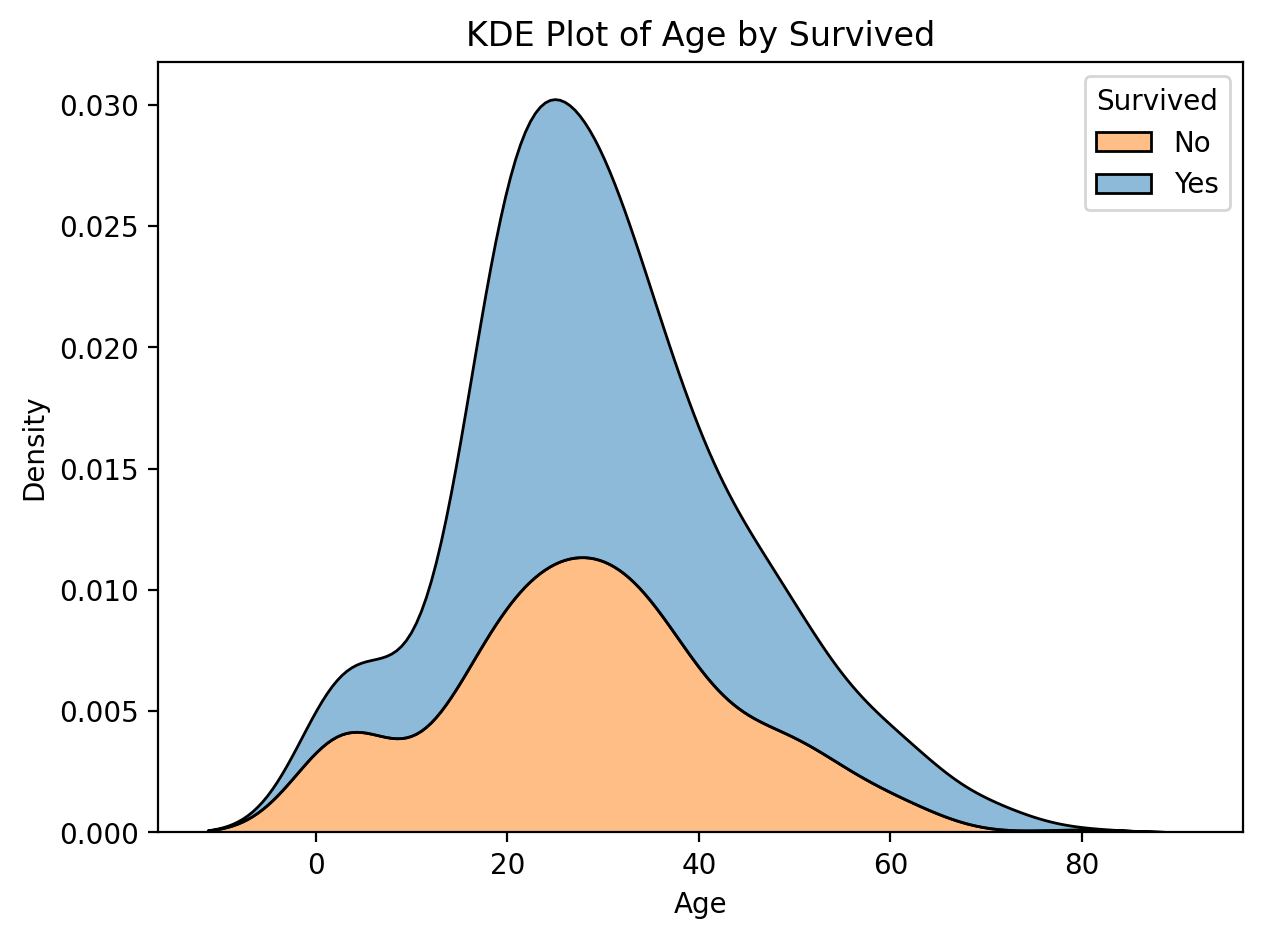

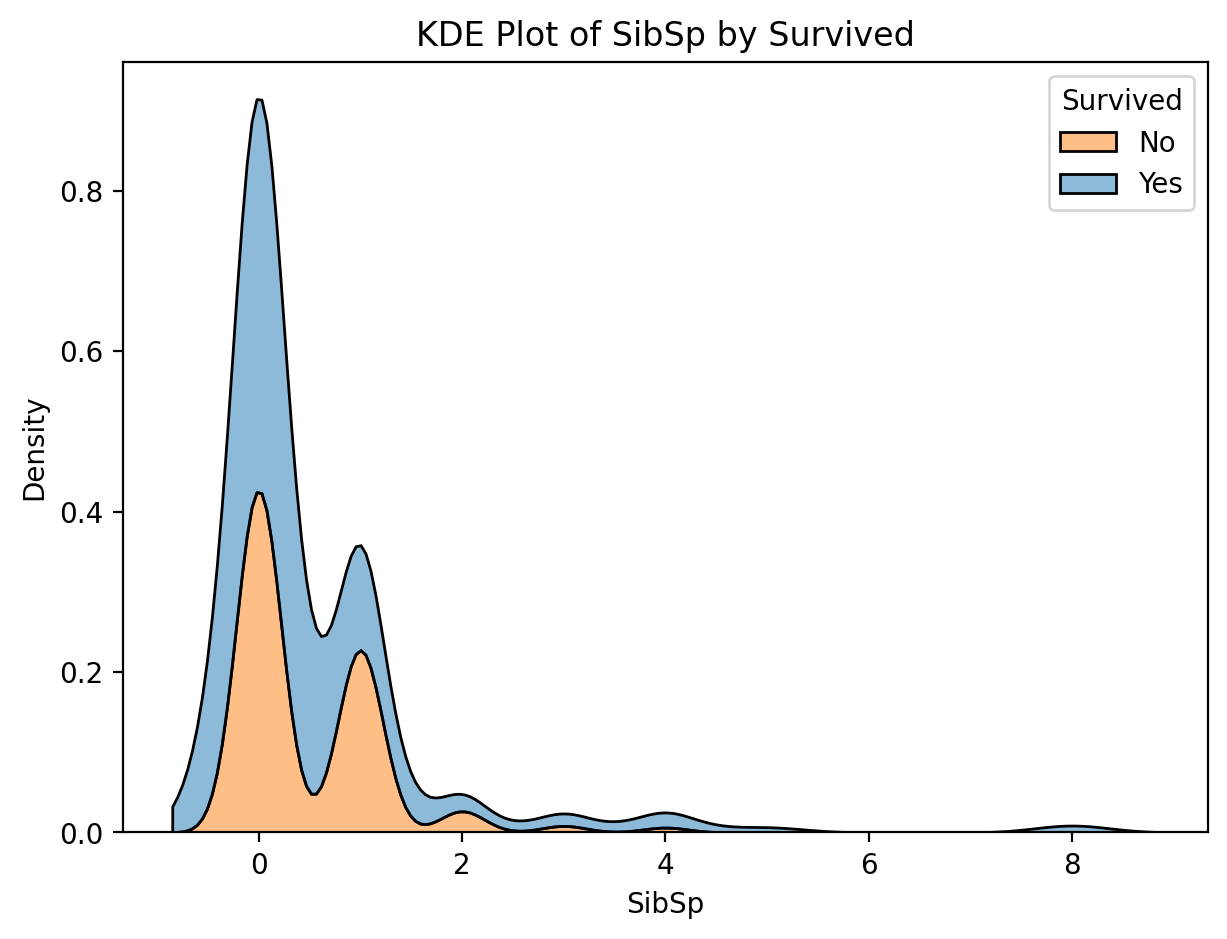

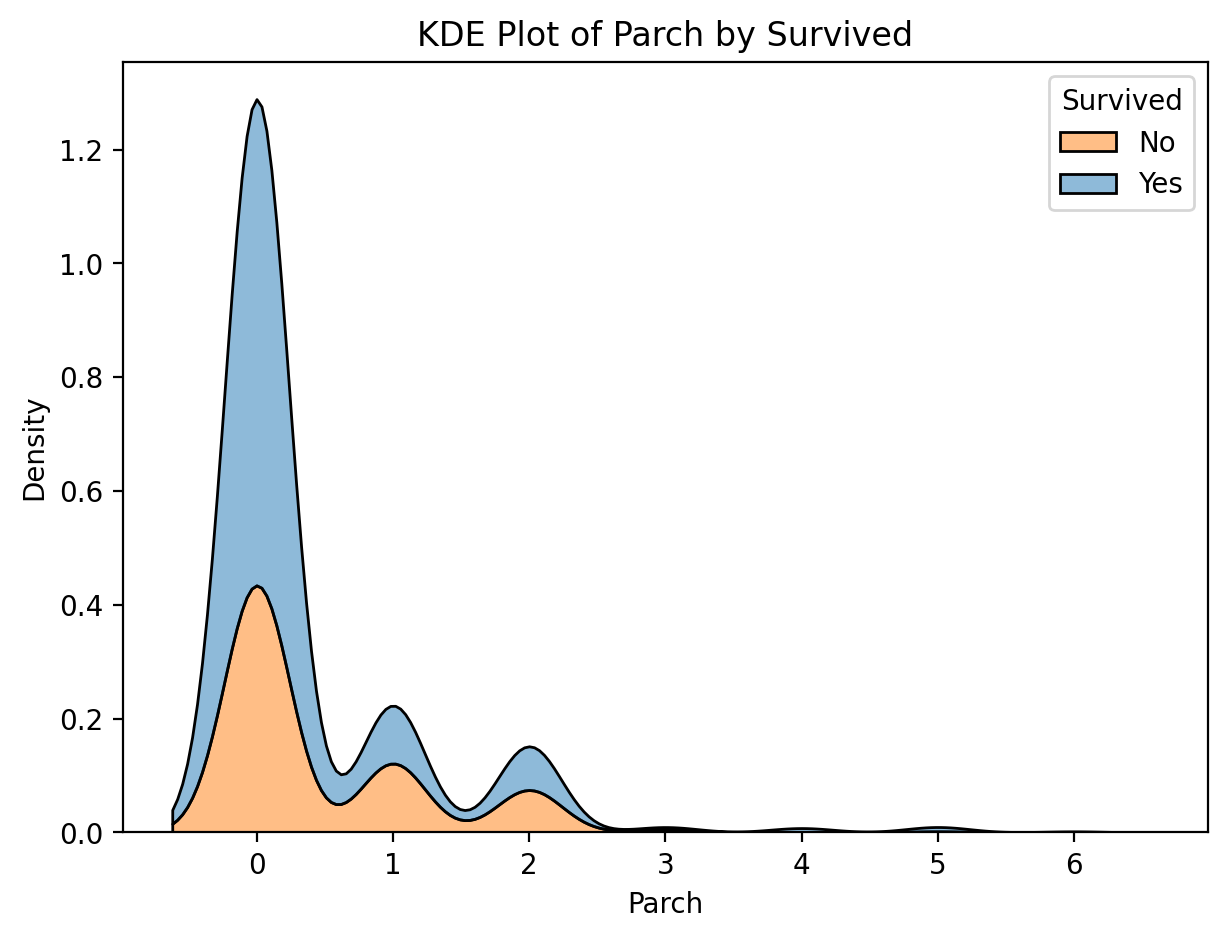

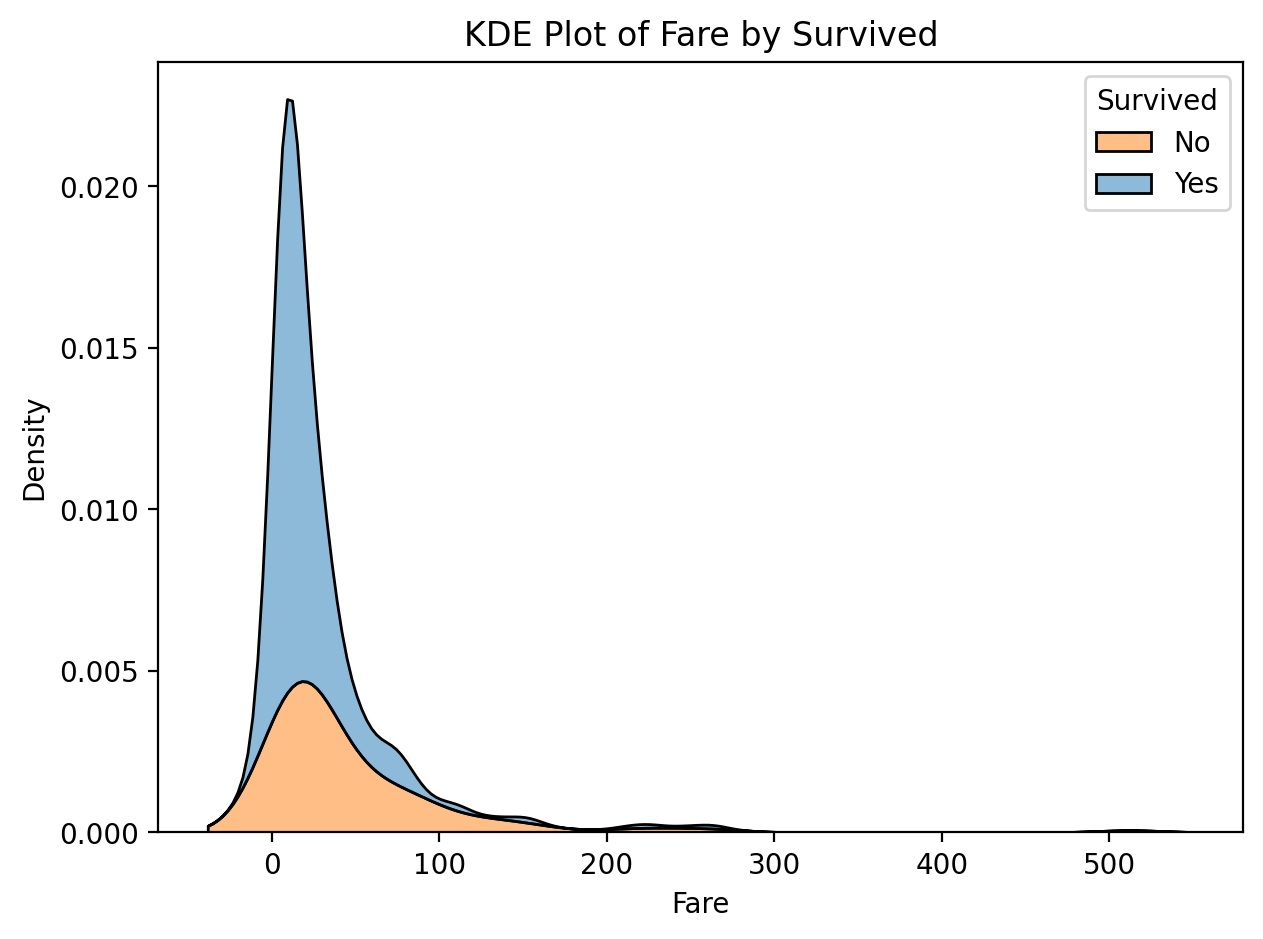

In [18]:
kde_plots(train, numerical_features, target_column)

### Combined Histograms and KDE Plots

In [19]:
def historgram_kde_plots(train, numerical_features, target_column) :
    print("\n--- Combined Histograms and KDE Plots of Numeric Features ---")
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=train, x=feature, hue=target_column, kde=True, multiple="stack")
        plt.title(f'Histogram and KDE of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Density / Frequency')
        plt.legend(title=target_column, labels=['No', 'Yes']) # Assuming 0 is 'No', 1 is 'Yes'
        plt.show()


--- Combined Histograms and KDE Plots of Numeric Features ---


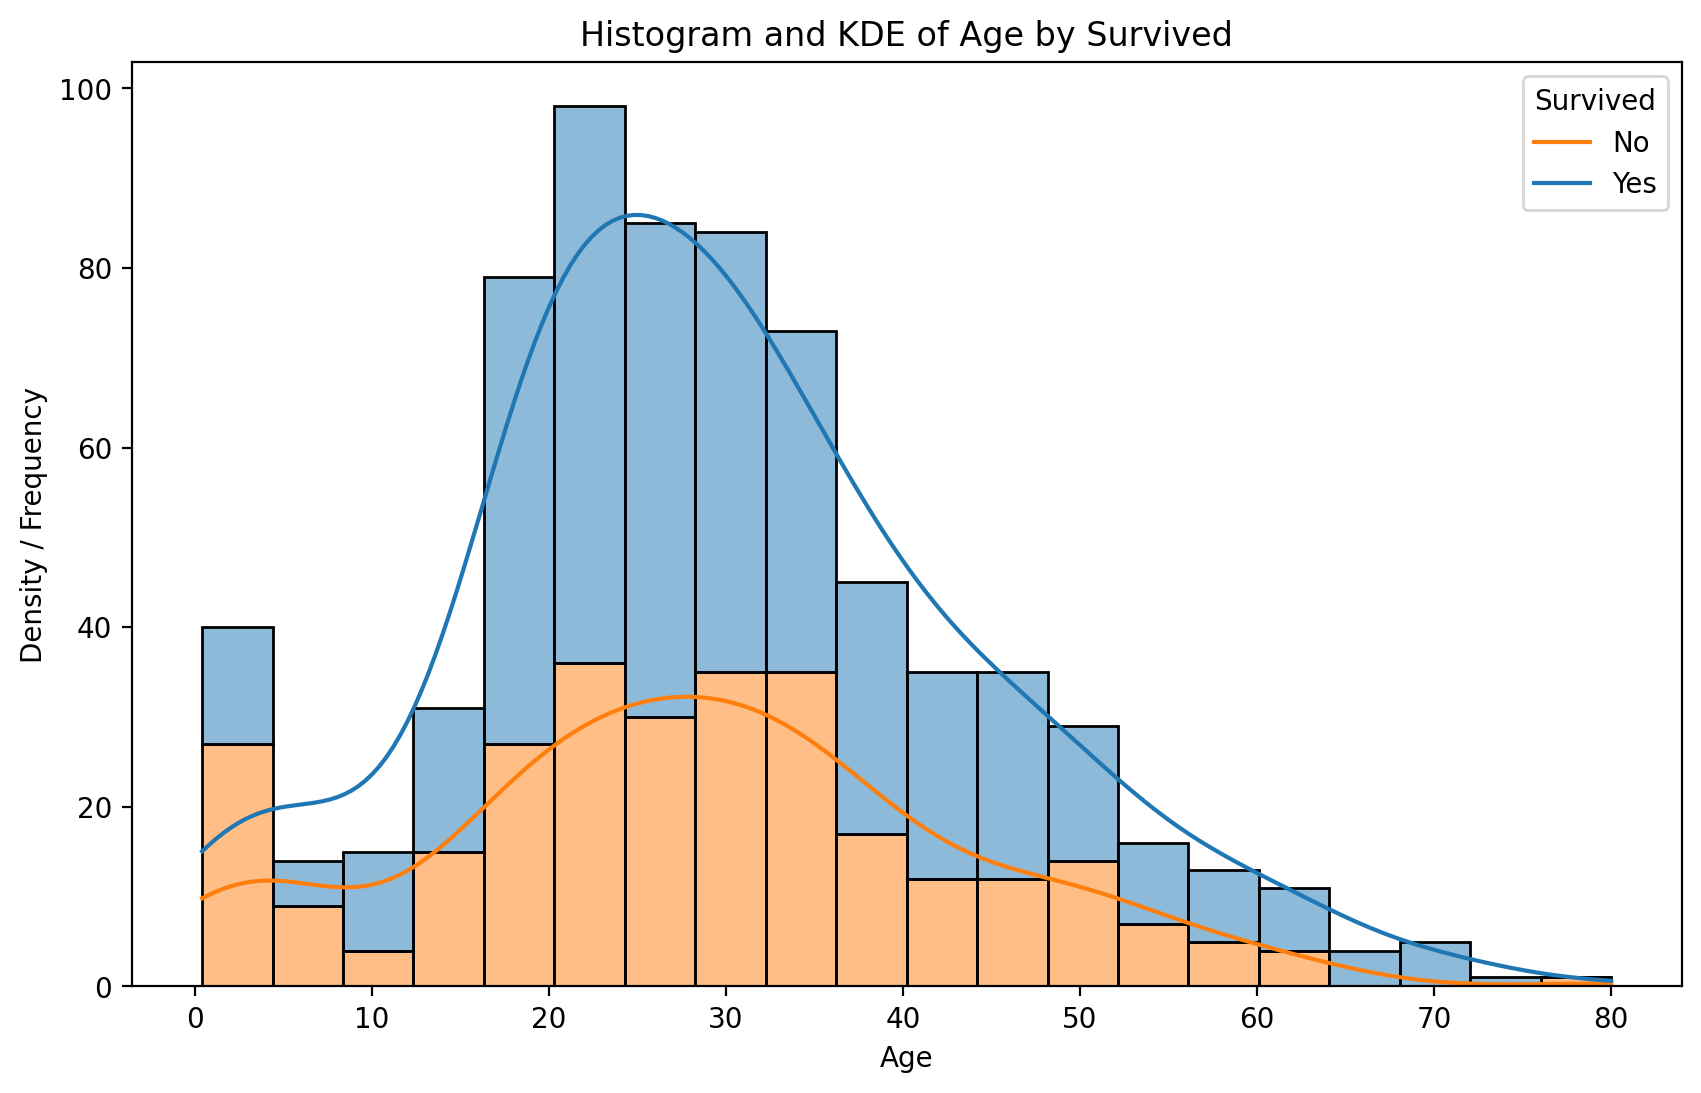

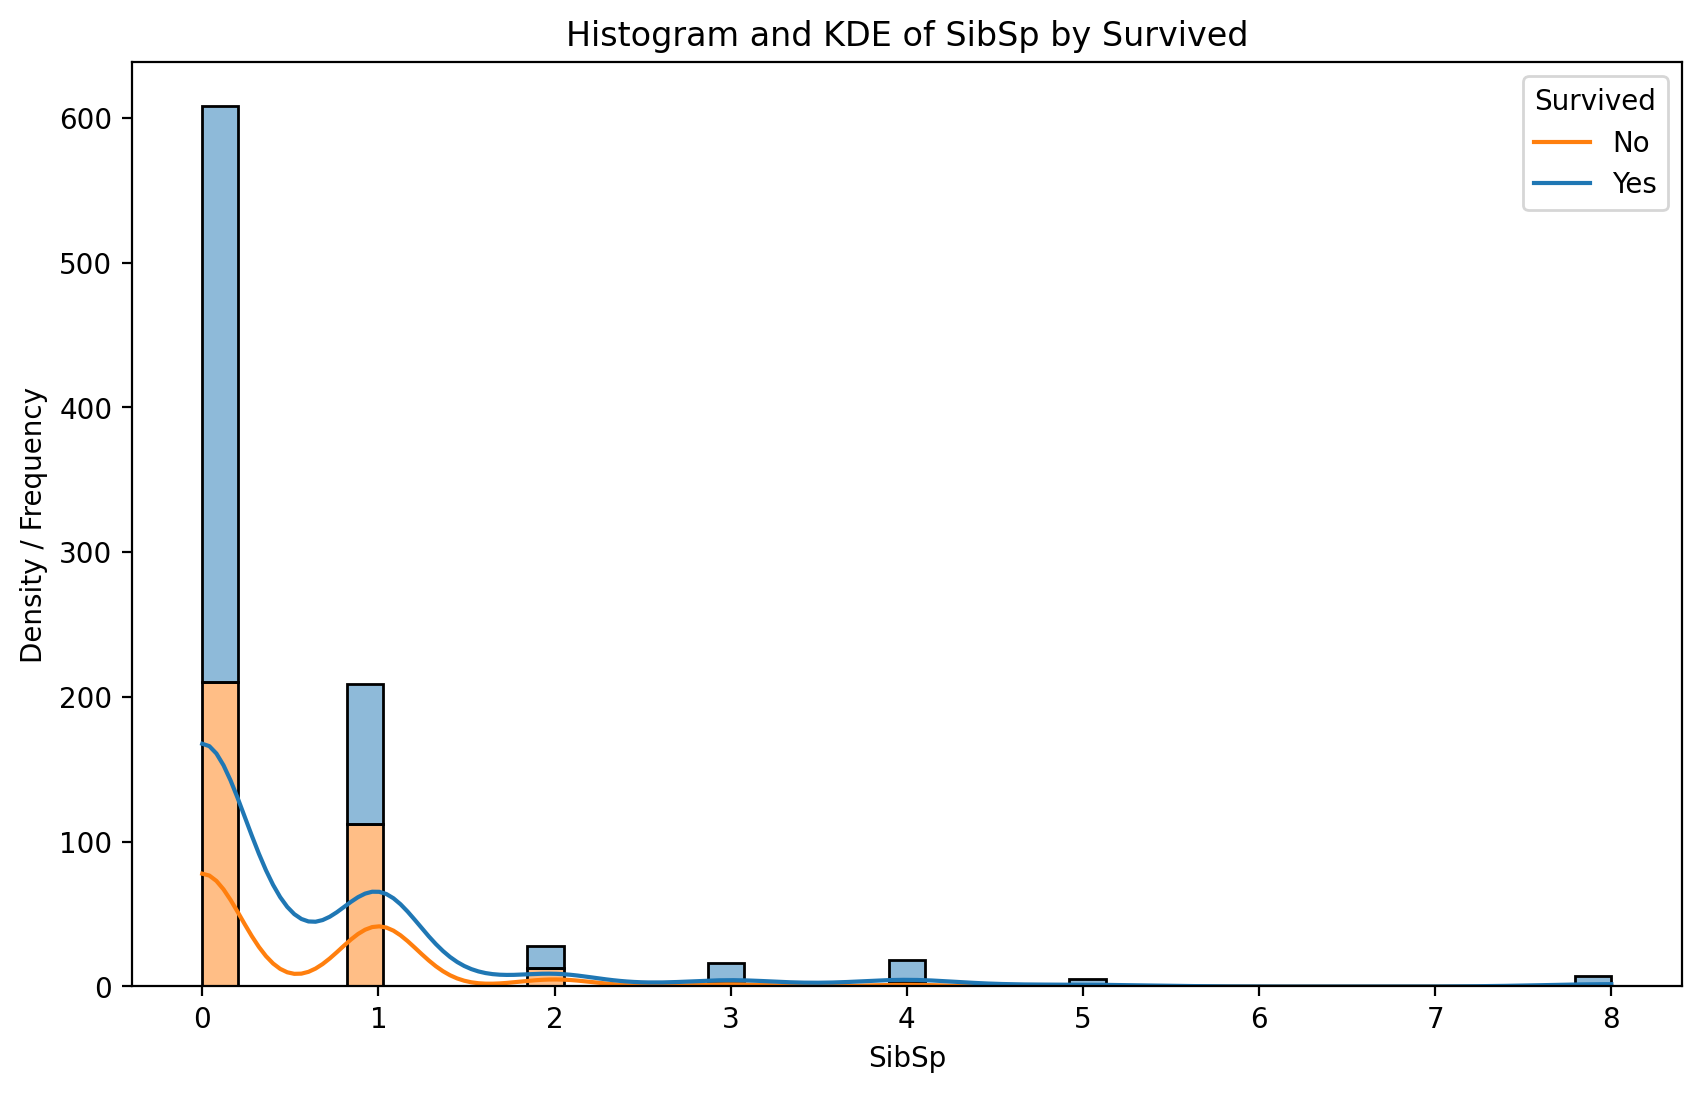

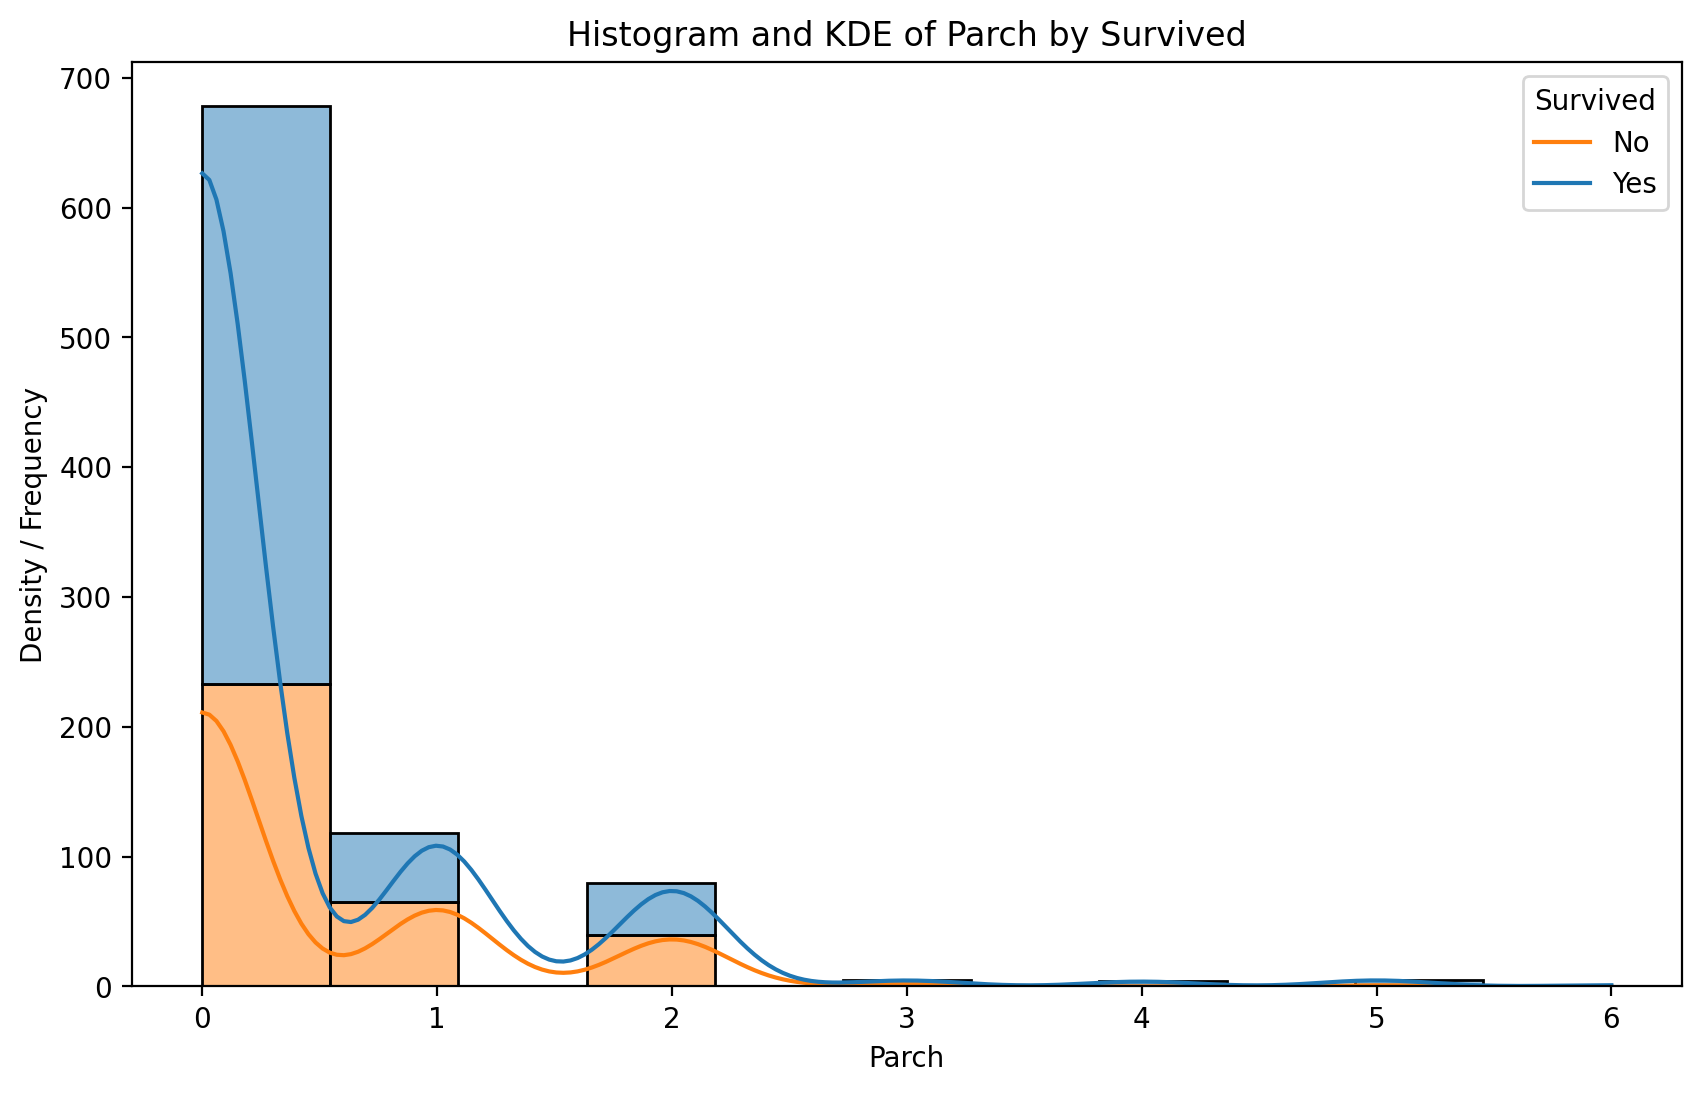

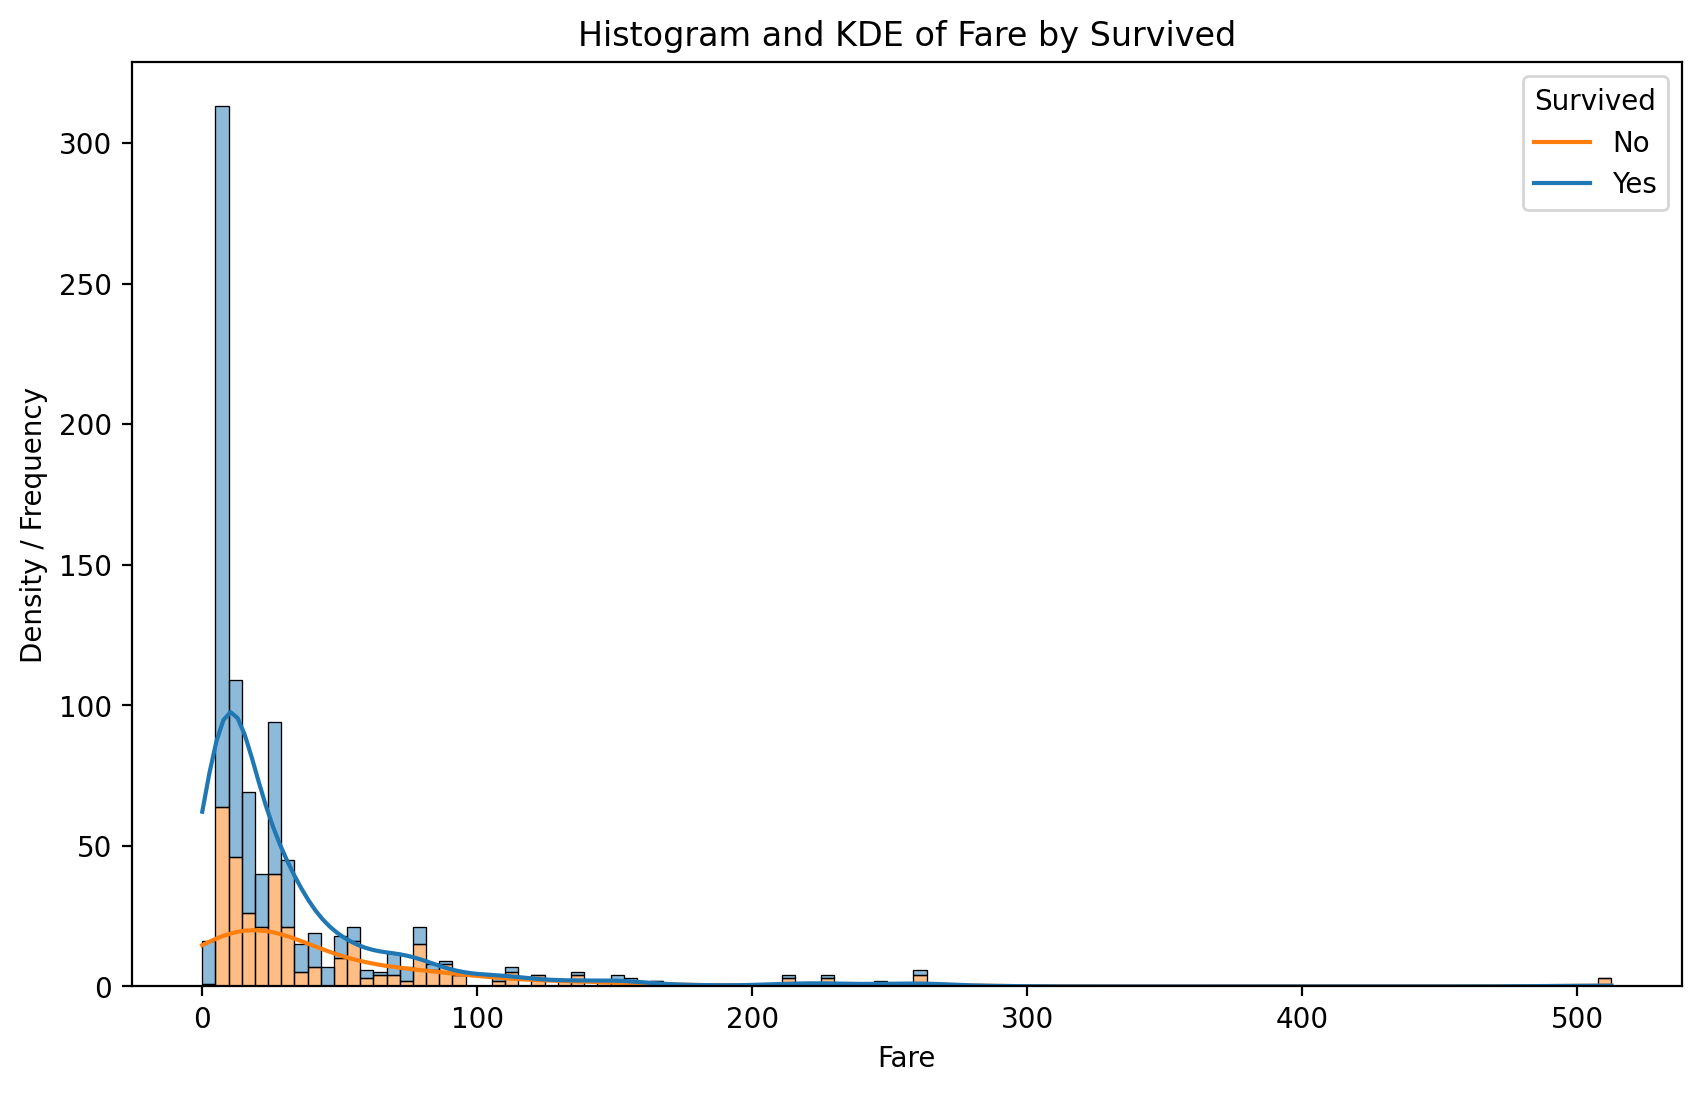

In [20]:
historgram_kde_plots(train, numerical_features, target_column)

### Pair Plots

In [21]:
def pair_plits(train) :
    sns.pairplot(train[['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']], hue='Survived')
    plt.suptitle('Pairwise Relationships of Features', y=1.02)
    plt.show()

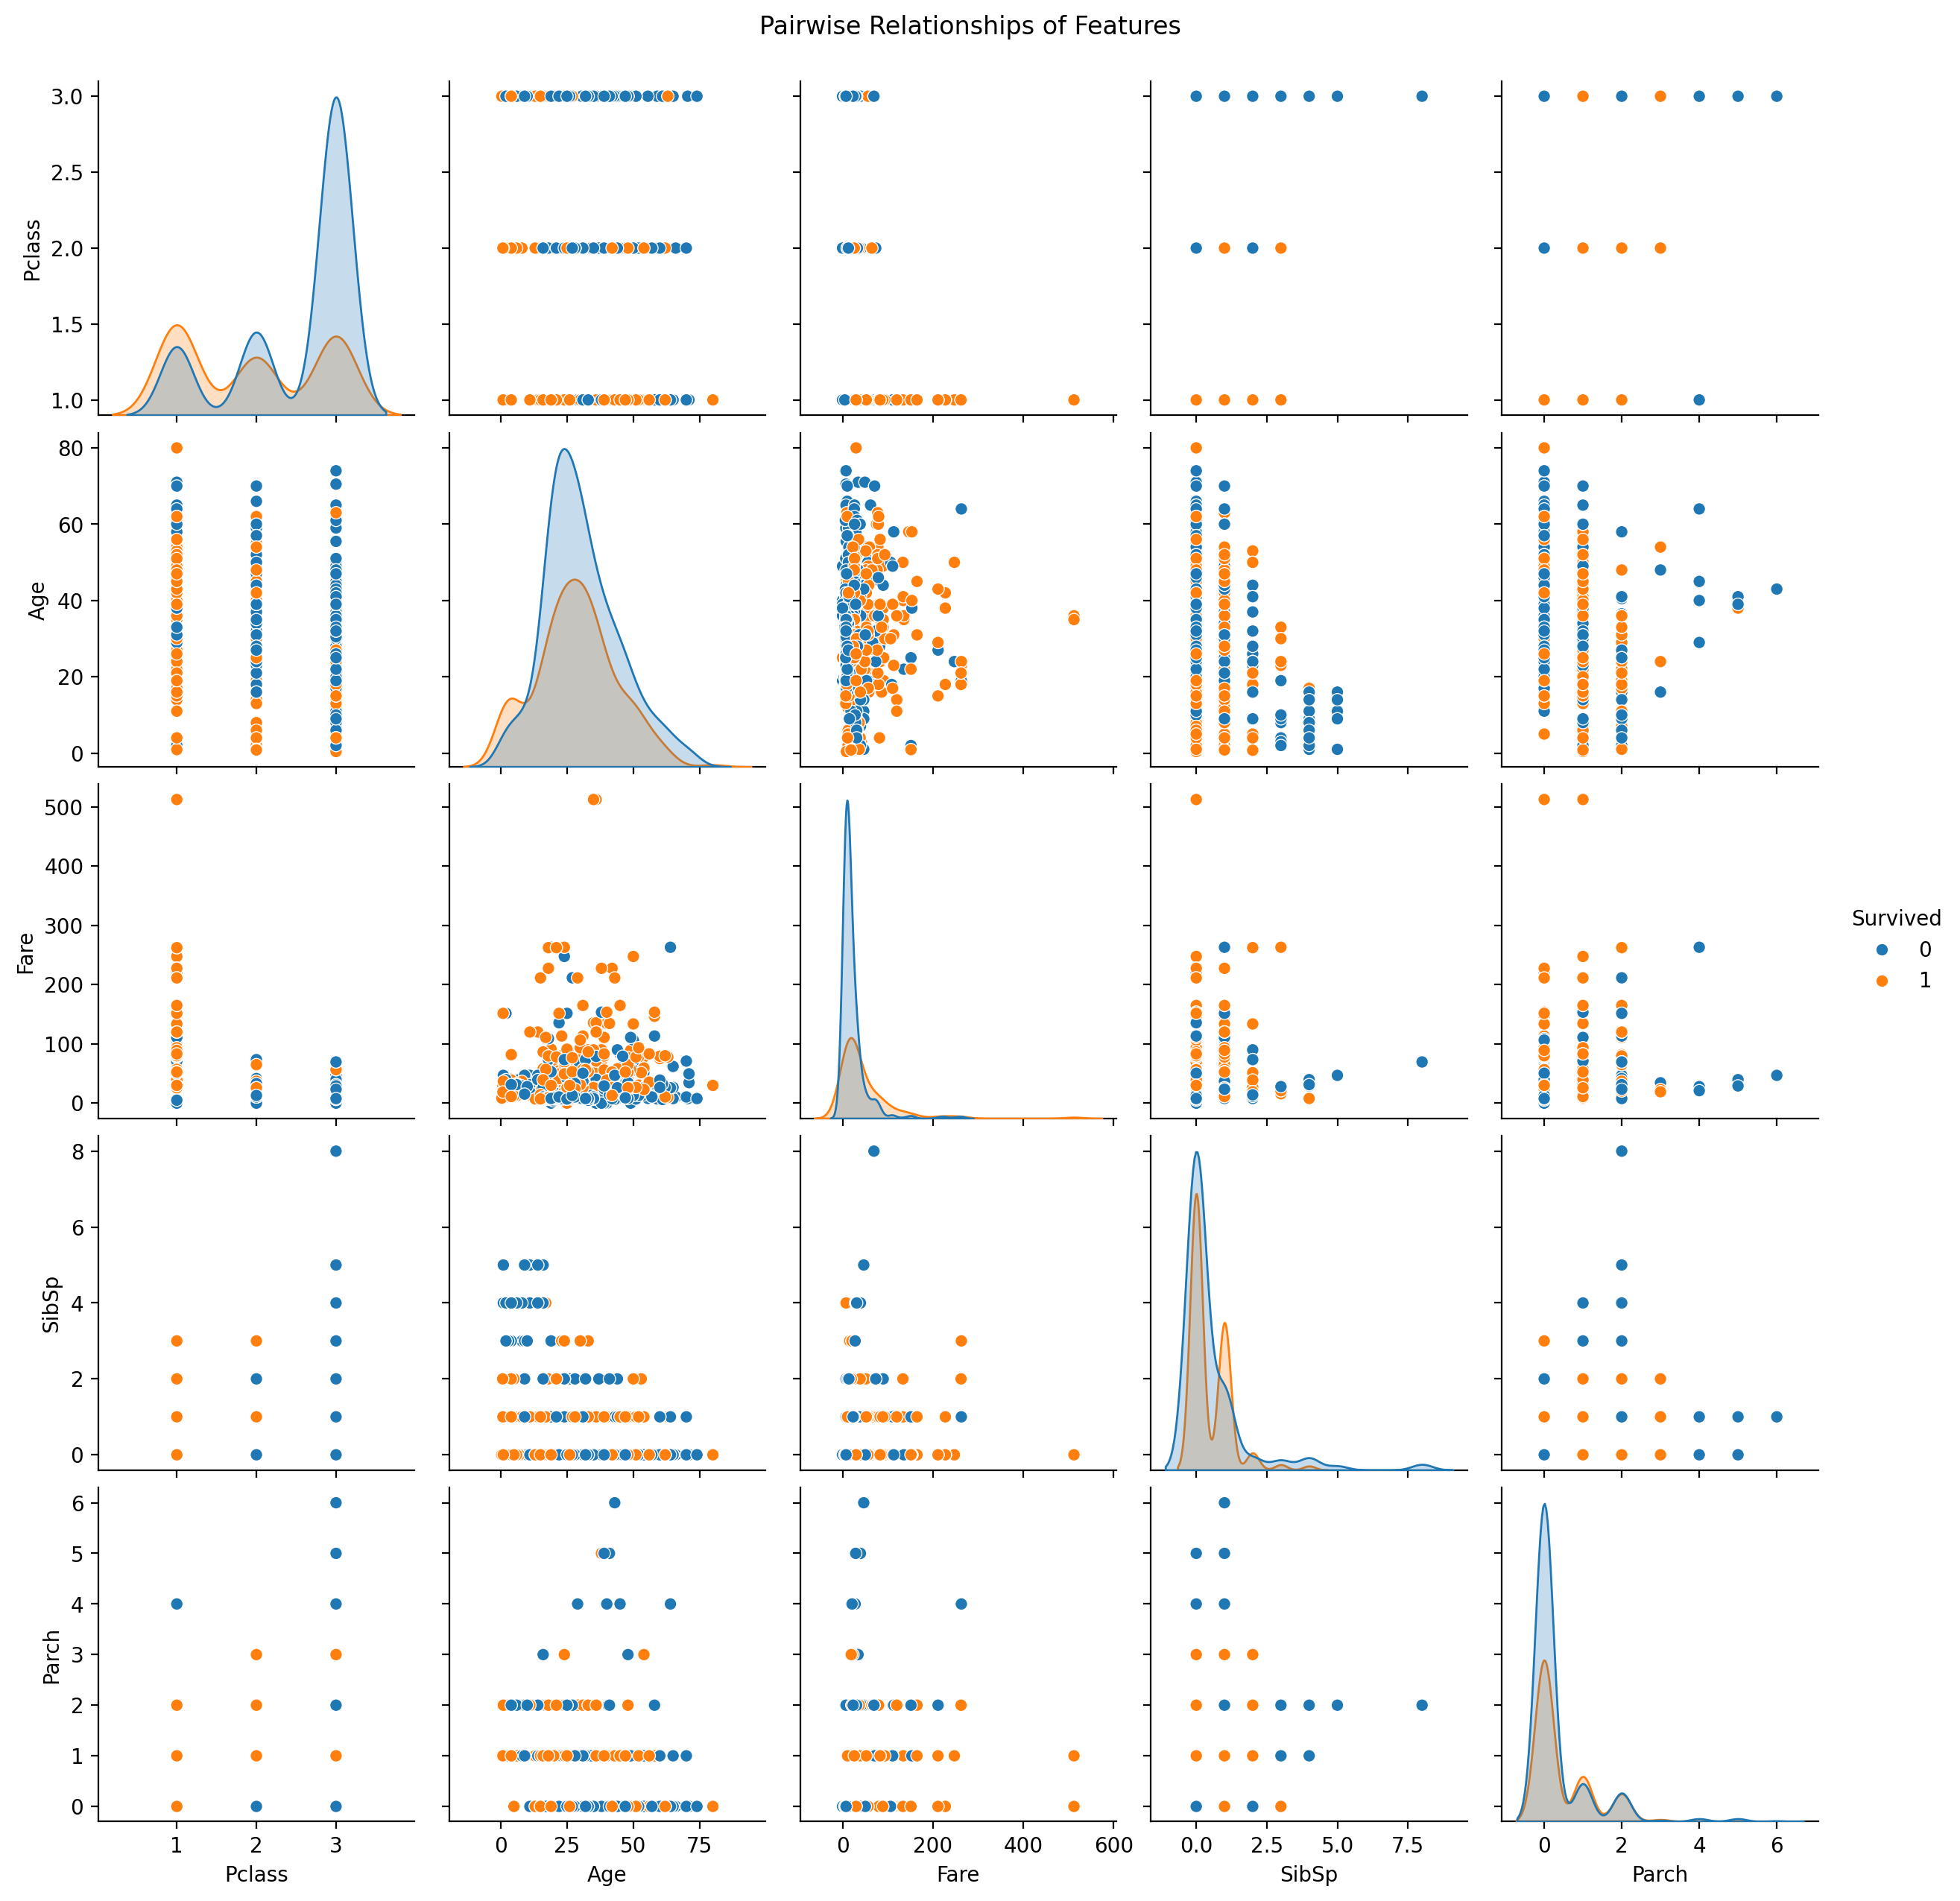

In [22]:
pair_plits(train)

### Target vs. Numerical Feature Analysis

In [23]:
# --- Target vs. Numerical Feature Analysis ---

def box_plots_numerical_features(train, numerical_features, target_column) :

    print("--- Boxplots of Numerical Features by Target ---")
    for feature in numerical_features:
        plt.figure(figsize=(7, 5))
        sns.boxplot(data=train, x=target_column, y=feature, hue=target_column)
        plt.title(f'Boxplot of {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Negative Class', 'Positive Class'])
        plt.show()
    
    print("\n--- Violin Plots of Numerical Features by Target ---")
    for feature in numerical_features:
        plt.figure(figsize=(7, 5))
        sns.violinplot(data=train, x=target_column, y=feature, split=True, inner="quart")
        plt.title(f'Violin Plot of {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Negative Class', 'Positive Class'])
        plt.show()

--- Boxplots of Numerical Features by Target ---


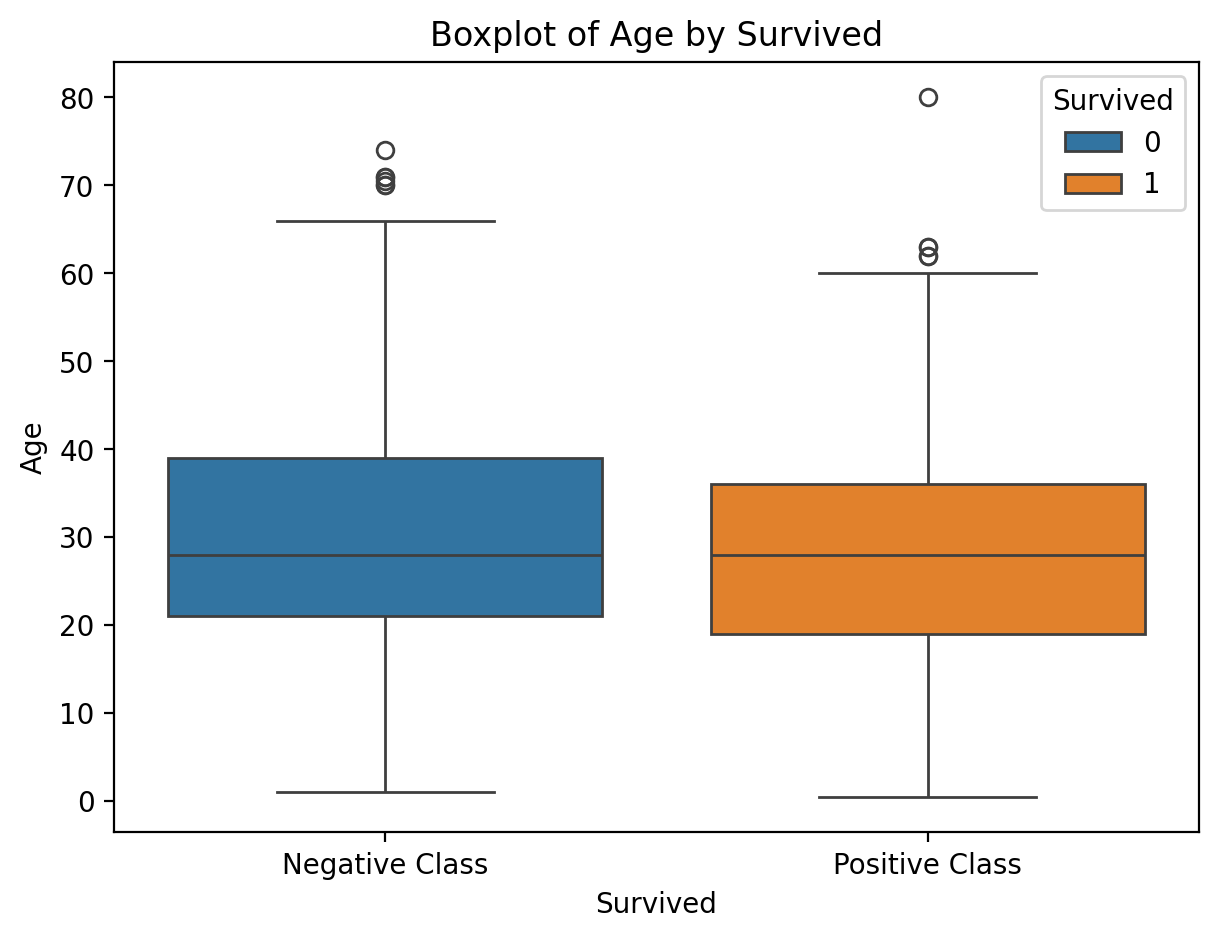

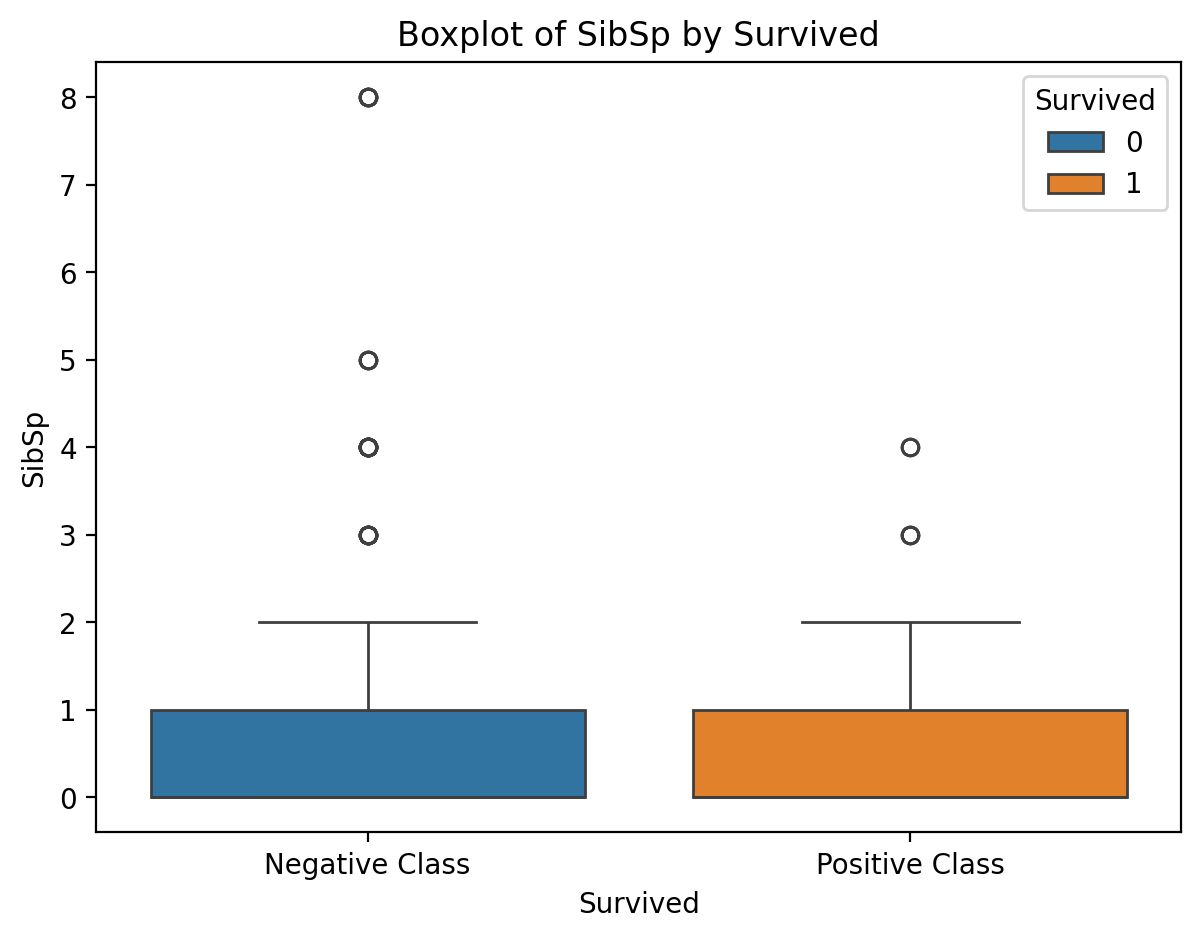

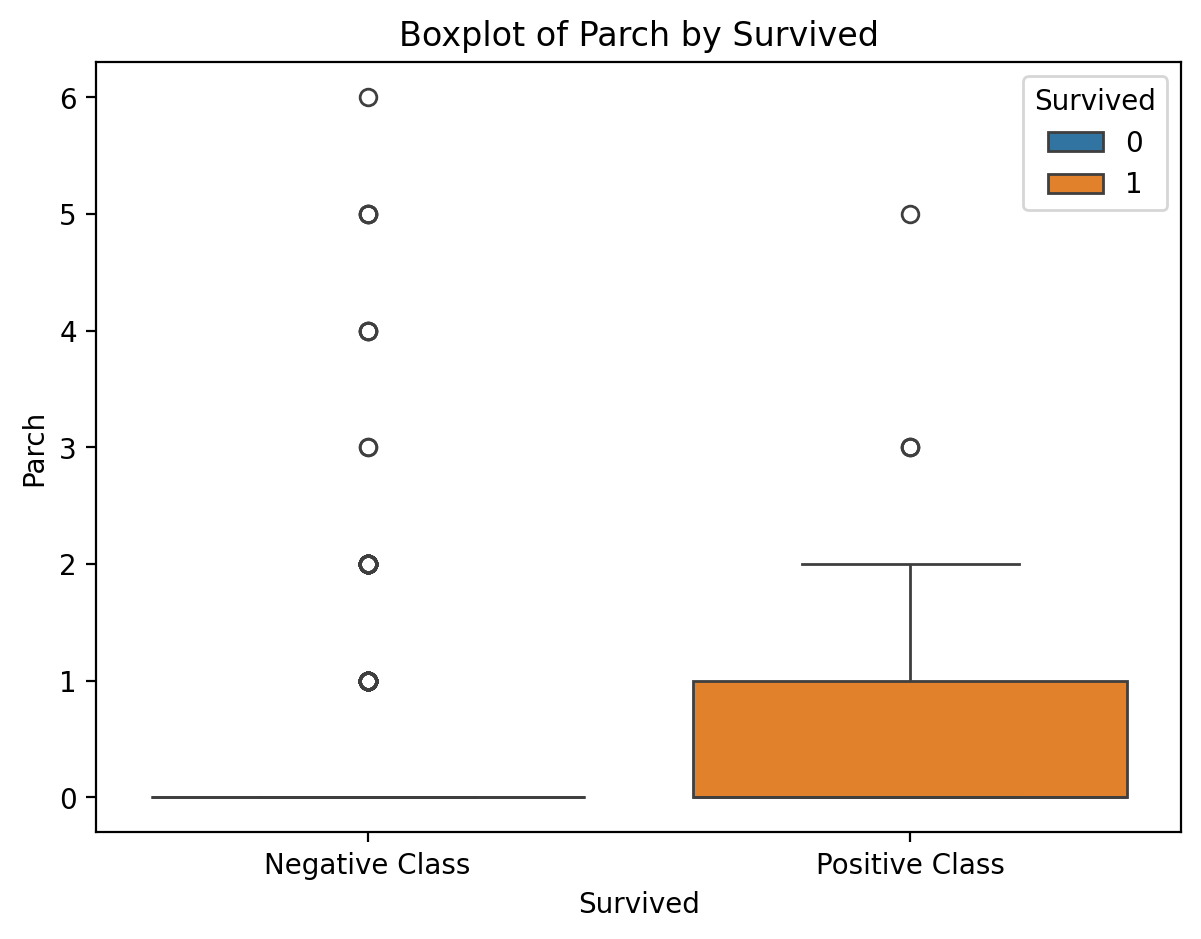

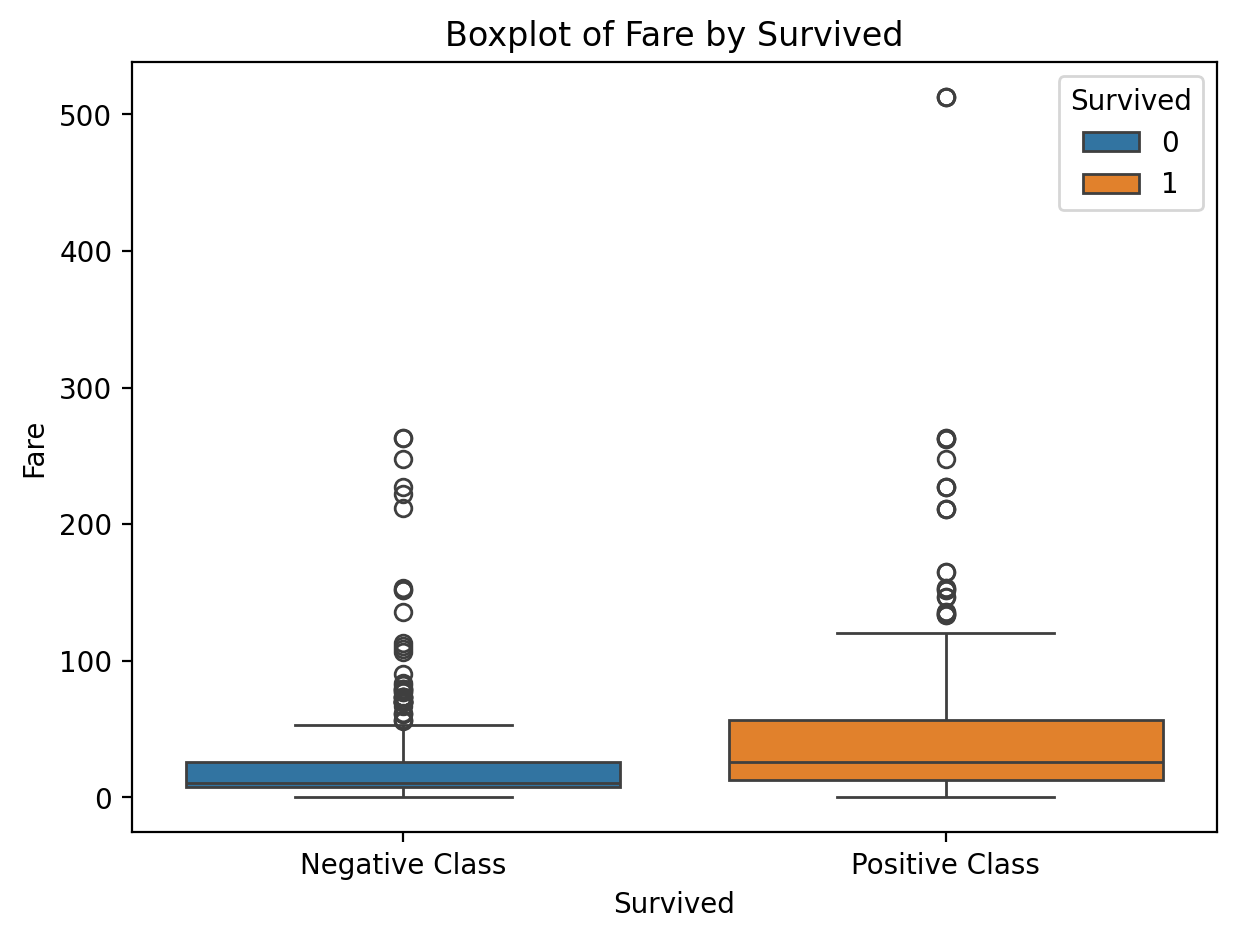


--- Violin Plots of Numerical Features by Target ---


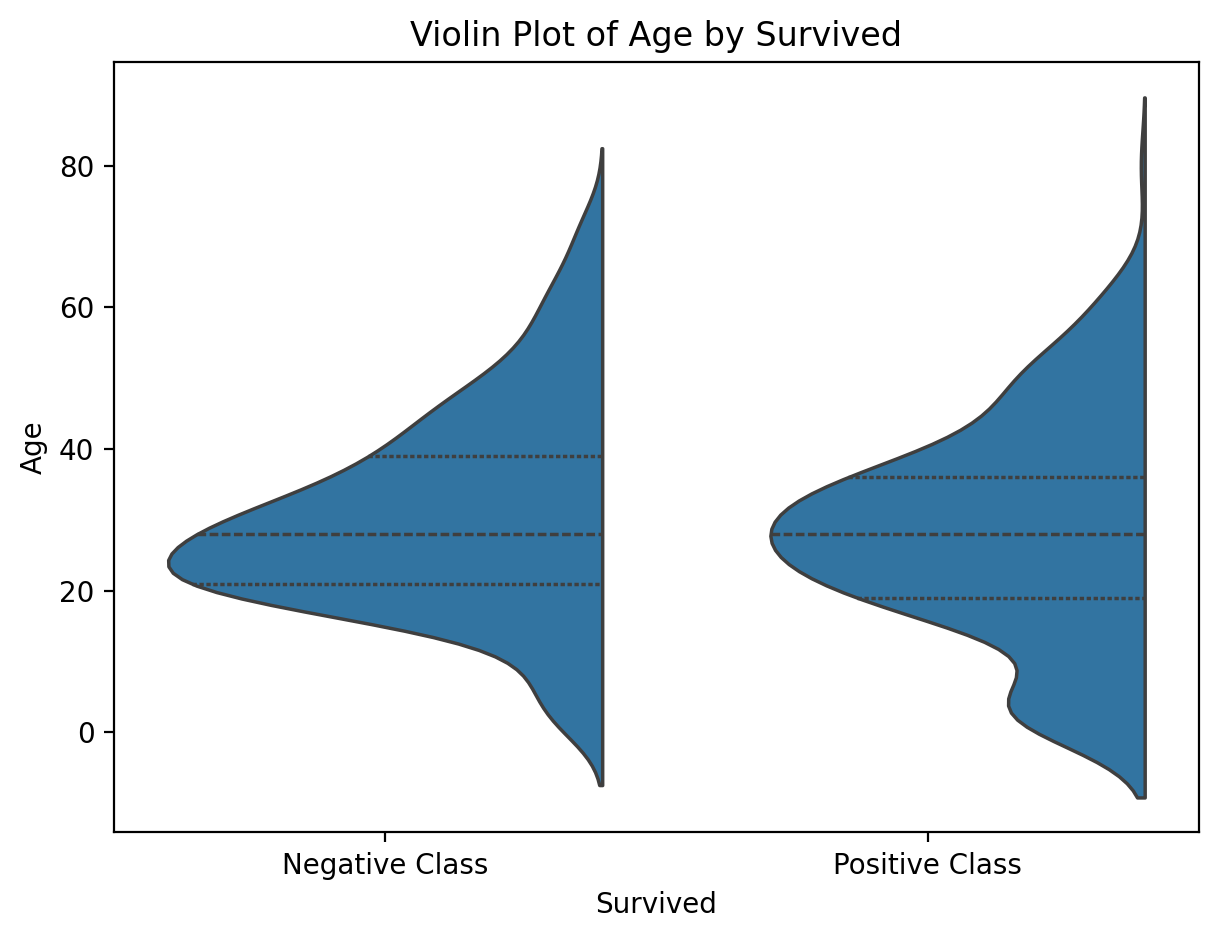

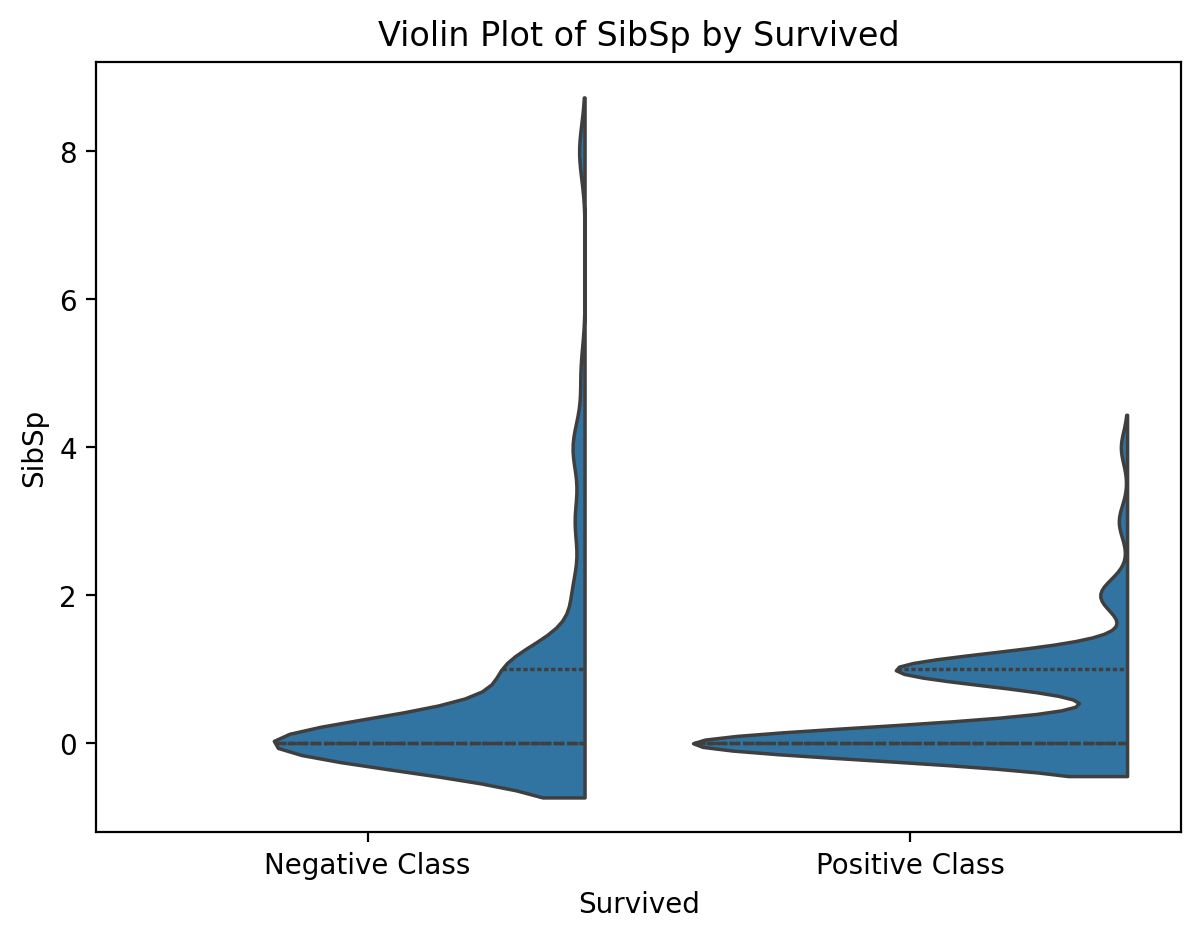

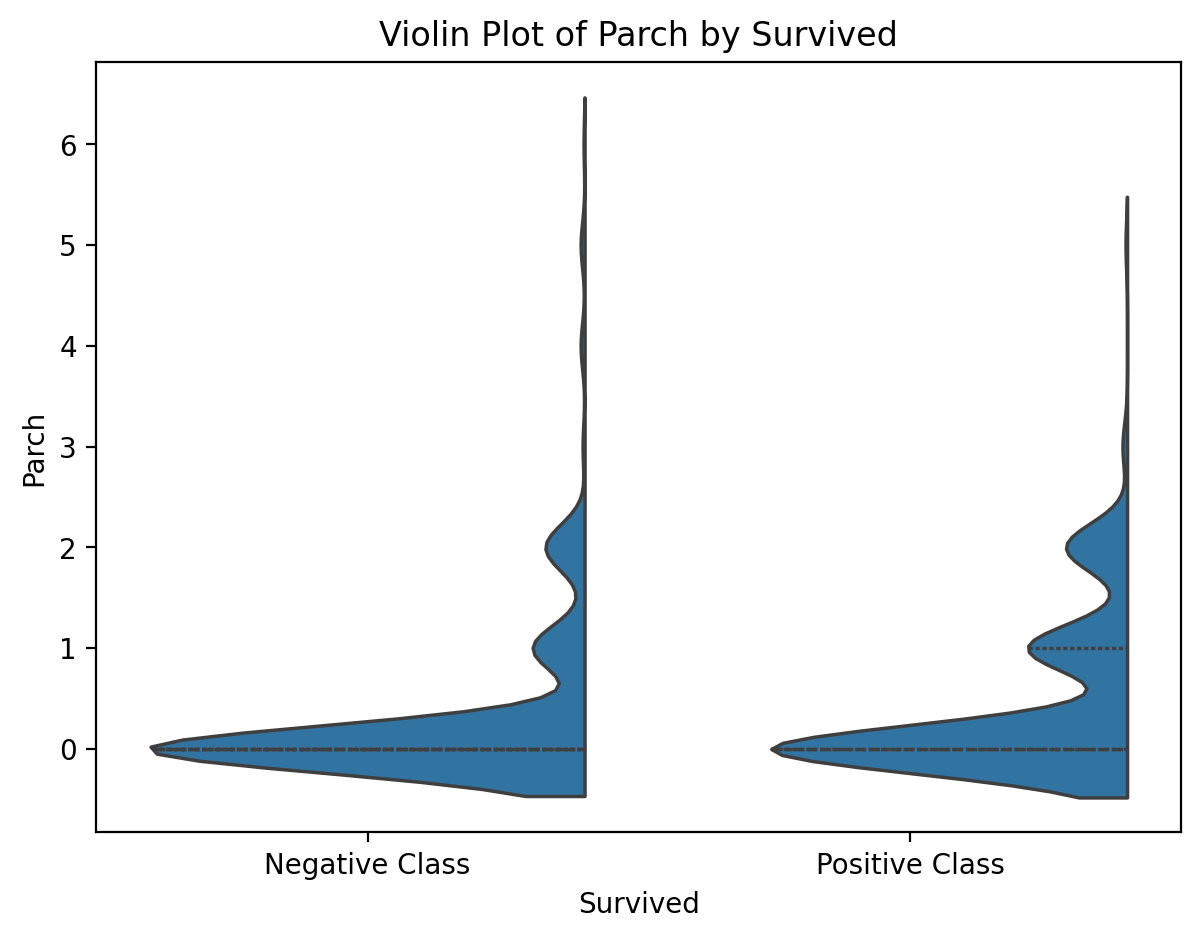

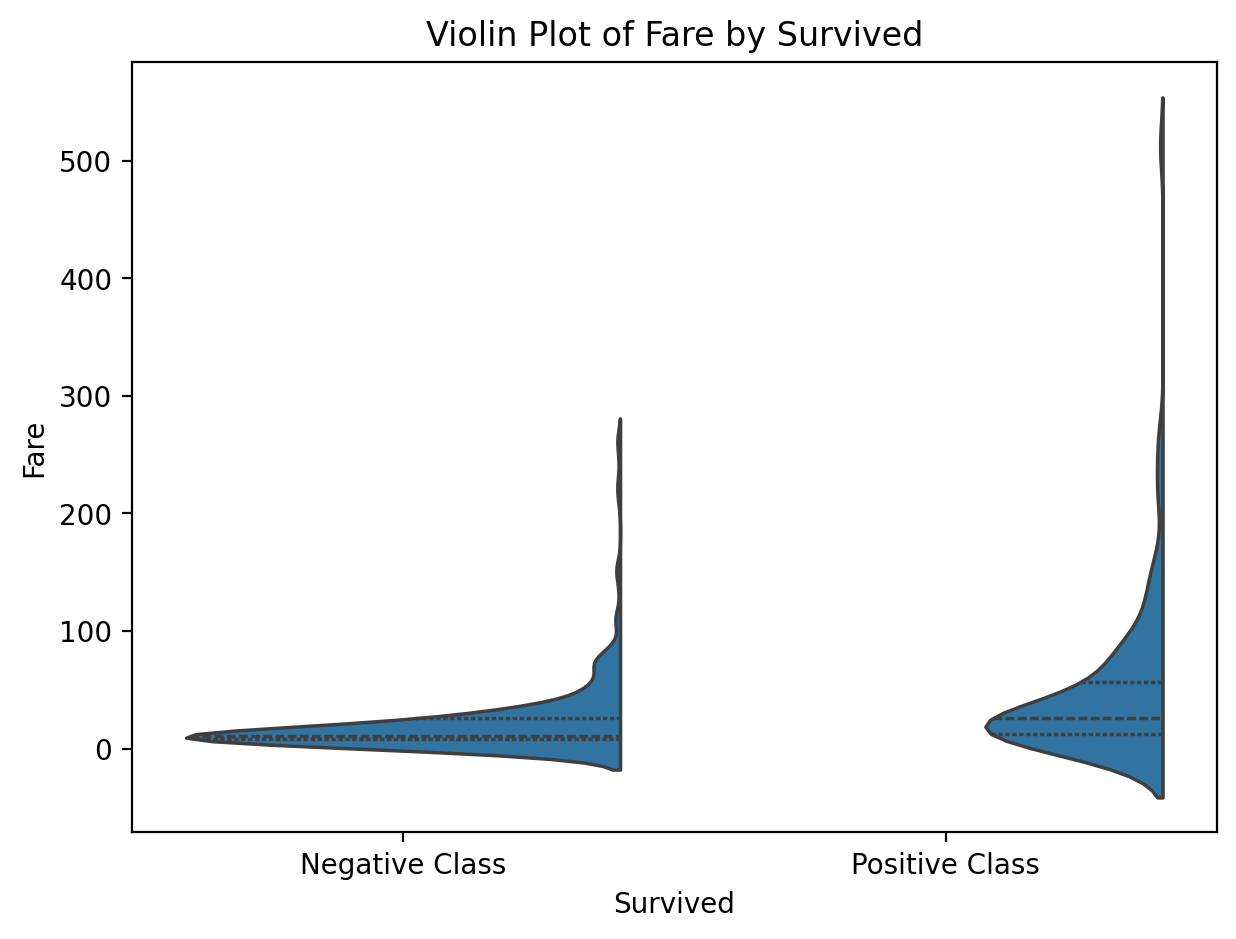

In [24]:
box_plots_numerical_features(train, numerical_features, target_column)

## Feature Engineering

In [25]:
# Fetch all the unique titles from the dataset

all_titles = []

for name_string in train["Name"] :
    comma_pos = name_string.find(',')
    dot_pos = name_string.find('.')
    title = name_string[comma_pos + 2:dot_pos]
    if title not in all_titles :
        all_titles.append(title)

print(all_titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']


In [26]:
# Function to return the title for a given name
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string)
    return np.nan

In [27]:
# Evalute the above function to each row and add it as a column

train['Title']=train['Name'].map(lambda x: substrings_in_string(x, all_titles))
test['Title']=test['Name'].map(lambda x: substrings_in_string(x, all_titles))

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

categorical_features['Title'] = train['Title']
categorical_features_pred['Title'] = test['Title']
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Title  
0      0         A/5 21171   7.2500   NaN        S    Mr  
1      0          PC 17599  71.2833   C85        C    Mr  
2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
3      0            113803  53.1000  C123        S    Mr  
4      0            37345

In [28]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked Title  
0  34.5      0      0   330911   7.8292   NaN        Q    Mr  
1  47.0      1      0   363272   7.0000   NaN        S    Mr  
2  62.0      0      0   240276   9.6875   NaN        Q    Mr  
3  27.0      0      0   315154   8.6625   NaN        S    Mr  
4  22.0      1      1  3101298  12.2875   NaN        S    Mr

In [29]:
# Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'NaN']

train['Deck']=train['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
test['Deck']=test['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))

categorical_features['Deck'] = train['Deck']
categorical_features_pred['Deck'] = test['Deck']
print(train['Deck'].head())

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Deck, dtype: object


In [30]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked Title Deck  
0  34.5      0      0   330911   7.8292   NaN        Q    Mr  NaN  
1  47.0      1      0   363272   7.0000   NaN        S    Mr  NaN  
2  62.0      0      0   240276   9.6875   NaN        Q    Mr  NaN  
3  27.0      0      0   315154   8.6625   NaN        S    Mr  NaN  
4  22.0      1      1  3101298  12.2875   NaN        S    Mr  NaN

In [31]:
# Creating new family_size column
train['Family_Size']=train['SibSp']+train['Parch']
test['Family_Size']=test['SibSp']+test['Parch']
numerical_features['Family_Size'] = train['Family_Size']

In [32]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked Title Deck  Family_Size  
0  34.5      0      0   330911   7.8292   NaN        Q    Mr  NaN            0  
1  47.0      1      0   363272   7.0000   NaN        S    Mr  NaN            1  
2  62.0      0      0   240276   9.6875   NaN        Q    Mr  NaN            0  
3  27.0      0      0   315154   8.6625   NaN        S    Mr  NaN            0  
4  22.0      1      1  3101298  12.2875   NaN        S    Mr  NaN            2

In [33]:
categorical_features = categorical_features.drop(columns = ['Cabin','Deck'])
categorical_features_pred = categorical_features_pred.drop(columns = ['Cabin','Deck'])

In [34]:
categorical_features.head(15)

Sex Embarked  Pclass   Title
0     male        S       3      Mr
1   female        C       1      Mr
2   female        S       3    Miss
3   female        S       1      Mr
4     male        S       3      Mr
5     male        Q       3      Mr
6     male        S       1      Mr
7     male        S       3  Master
8   female        S       3      Mr
9   female        C       2      Mr
10  female        S       3    Miss
11  female        S       1    Miss
12    male        S       3      Mr
13    male        S       3      Mr
14  female        S       3    Miss

In [35]:
categorical_features_pred.head(15)

Sex Embarked  Pclass Title
0     male        Q       3    Mr
1   female        S       3    Mr
2     male        Q       2    Mr
3     male        S       3    Mr
4   female        S       3    Mr
5     male        S       3    Mr
6   female        Q       3  Miss
7     male        S       2    Mr
8   female        C       3    Mr
9     male        S       3    Mr
10    male        S       3    Mr
11    male        S       1    Mr
12  female        S       1    Mr
13    male        S       2    Mr
14  female        S       1    Mr

In [36]:
numerical_features.head(10)

Age  SibSp  Parch     Fare  Family_Size
0  22.0      1      0   7.2500            1
1  38.0      1      0  71.2833            1
2  26.0      0      0   7.9250            0
3  35.0      1      0  53.1000            1
4  35.0      0      0   8.0500            0
5   NaN      0      0   8.4583            0
6  54.0      0      0  51.8625            0
7   2.0      3      1  21.0750            4
8  27.0      0      2  11.1333            2
9  14.0      1      0  30.0708            1

In [37]:
train.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked   Title Deck  Family_Size  
0      0         A/5 21171   7.2500   NaN        S      Mr  NaN            1  
1      0          PC 17599  71.2833   C85        C      Mr    C            1  
2      0  STON/O2. 3101282   7.9250   NaN        S    Miss  NaN            0  
3      0            113803  53.1000  C123        S      Mr    C            1  
4      0            373450   8.0500   NaN        S      Mr  NaN            0  
5      0            330877   8.4583   NaN        Q      Mr  NaN            0  
6      0             17463  51.8625   E46        S      Mr    E            0  
7      1            349909  21.0750   NaN        S  Master  NaN            4  
8      2            347742  11.1333   NaN        S      Mr  NaN            2  
9      0            237736  30.0708   NaN        C      Mr  NaN            1

In [38]:
train = train.drop(columns = ['Name','Ticket','PassengerId','Cabin','Deck'])
test = test.drop(columns = ['Name','Ticket','PassengerId','Cabin','Deck'])

In [39]:
train.head(10)

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked   Title  \
0         0       3    male  22.0      1      0   7.2500        S      Mr   
1         1       1  female  38.0      1      0  71.2833        C      Mr   
2         1       3  female  26.0      0      0   7.9250        S    Miss   
3         1       1  female  35.0      1      0  53.1000        S      Mr   
4         0       3    male  35.0      0      0   8.0500        S      Mr   
5         0       3    male   NaN      0      0   8.4583        Q      Mr   
6         0       1    male  54.0      0      0  51.8625        S      Mr   
7         0       3    male   2.0      3      1  21.0750        S  Master   
8         1       3  female  27.0      0      2  11.1333        S      Mr   
9         1       2  female  14.0      1      0  30.0708        C      Mr   

   Family_Size  
0            1  
1            1  
2            0  
3            1  
4            0  
5            0  
6            0  
7            4  
8            2  
9            1

In [40]:
test.head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked Title  Family_Size
0       3    male  34.5      0      0   7.8292        Q    Mr            0
1       3  female  47.0      1      0   7.0000        S    Mr            1
2       2    male  62.0      0      0   9.6875        Q    Mr            0
3       3    male  27.0      0      0   8.6625        S    Mr            0
4       3  female  22.0      1      1  12.2875        S    Mr            2

In [41]:
def encode_categorical_features(categorical_features) :
    # label_encoders = {}
    X_encoded = categorical_features.copy()
    i = 0
    for col in categorical_features:
        print(categorical_features.columns[i])
        # le = skl.preprocessing.LabelEncoder()
        # X_encoded[col] = le.fit_transform(X_encoded[col])
        # label_encoders[col] = le
        X_encoded_dummies = pd.get_dummies(categorical_features[col], prefix=categorical_features.columns[i])
        X_encoded = pd.concat([X_encoded, X_encoded_dummies], axis=1)
        X_encoded.drop(col, axis=1, inplace=True)
        i += 1
        
    return X_encoded

In [42]:
# print(type(categorical_features_pred))
# categorical_features_pred = categorical_features_pred.to_frame()
# print(type(categorical_features_pred))
# categorical_features_pred.head()

In [43]:
X = train.drop([target_column], axis=1)
X_Pred = test
print(type(X_Pred))
y = train[target_column]
categorical_features_encoded = encode_categorical_features(categorical_features)
categorical_features_encoded_pred = encode_categorical_features(categorical_features_pred)
categorical_features_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Sex
Embarked
Pclass
Title
Sex
Embarked
Pclass
Title


Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  \
0       False      True       False       False        True     False   
1        True     False        True       False       False      True   
2        True     False       False       False        True     False   
3        True     False       False       False        True      True   
4       False      True       False       False        True     False   

   Pclass_2  Pclass_3  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0     False      True         False       False      True      False   
1     False     False         False       False      True      False   
2     False      True         False        True     False      False   
3     False     False         False       False      True      False   
4     False      True         False       False      True      False   

   Title_the Countess  
0               False  
1               False  
2               False  
3               False  
4               False

In [44]:
X = pd.concat([train, categorical_features_encoded], axis=1)
X_Pred = pd.concat([test, categorical_features_encoded_pred], axis=1)
X.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked Title  \
0         0       3    male  22.0      1      0   7.2500        S    Mr   
1         1       1  female  38.0      1      0  71.2833        C    Mr   
2         1       3  female  26.0      0      0   7.9250        S  Miss   
3         1       1  female  35.0      1      0  53.1000        S    Mr   
4         0       3    male  35.0      0      0   8.0500        S    Mr   

   Family_Size  ...  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  \
0            1  ...       False        True     False     False      True   
1            1  ...       False       False      True     False     False   
2            0  ...       False        True     False     False      True   
3            1  ...       False        True      True     False     False   
4            0  ...       False        True     False     False      True   

   Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_the Countess  
0         False       False      True      False               False  
1         False       False      True      False               False  
2         False        True     False      False               False  
3         False       False      True      False               False  
4         False       False      True      False               False  

[5 rows x 23 columns]

In [45]:
# Handling the missing values

import warnings
warnings.filterwarnings("ignore")

X['Age_Missing'] = X['Age'].isnull().astype(int)
X_Pred['Age_Missing'] = X_Pred['Age'].isnull().astype(int)

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return X[X['Pclass'] == 1]['Age'].median()
        elif Pclass == 2:
            return X[X['Pclass'] == 2]['Age'].median()
        else:
            return X[X['Pclass'] == 3]['Age'].median()
    return Age

X['Age'] = X[['Age', 'Pclass']].apply(impute_age, axis=1)
X_Pred['Age'] = X_Pred[['Age', 'Pclass']].apply(impute_age, axis=1)

print(f"Number of NaN values in Age after Pclass-based imputation: {X['Age'].isna().sum()}")
print(f"Number of NaN values in Age after Pclass-based imputation: {X_Pred['Age'].isna().sum()}")

Number of NaN values in Age after Pclass-based imputation: 0
Number of NaN values in Age after Pclass-based imputation: 0


In [46]:
# Get indices of rows with missing 'Embarked' values
dropped_indices = X[X['Embarked'].isna()].index

# Drop rows from X
X.dropna(subset=['Embarked'], inplace=True)

# Drop corresponding rows from y using the same indices
y.drop(index=dropped_indices, inplace=True)
categorical_features_encoded.drop(index=dropped_indices, inplace=True)

In [47]:
X.drop(columns=['Title_the Countess'], inplace=True)

In [48]:
X.isna().sum()

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
Family_Size     0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Age_Missing     0
dtype: int64

In [49]:
X_Pred.isna().sum()

Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            1
Embarked        0
Title           0
Family_Size     0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Age_Missing     0
dtype: int64

### Mutual Information Scores

In [50]:
print(X.shape)
print(y.shape)
print(y.index.equals(X.index))  # Should return True

(889, 23)
(889,)
True


In [51]:
print(X_Pred.shape)

(418, 22)


In [52]:
def mutual_information_scores(X, y) :
    # Calculate Mutual Information Scores
    mutual_info = skl.feature_selection.mutual_info_classif(categorical_features_encoded, y, random_state=42)
    
    # Create a Series of Feature Names and their MI Scores
    mi_scores = pd.Series(mutual_info, index=categorical_features_encoded.columns)
    
    # Sort the MI scores in descending order
    mi_scores_sorted = mi_scores.sort_values(ascending=False)
    
    # Display the Mutual Information Scores
    print("--- Feature-Target Mutual Information Scores ---")
    print(mi_scores_sorted)

In [53]:
mutual_information_scores(X, y)

--- Feature-Target Mutual Information Scores ---
Sex_male              0.170057
Sex_female            0.162528
Title_Mr              0.072753
Title_Miss            0.056088
Pclass_1              0.041751
Pclass_3              0.039747
Embarked_S            0.028018
Title_Mrs             0.025819
Embarked_C            0.023361
Pclass_2              0.011534
Embarked_Q            0.008394
Title_the Countess    0.005387
Title_Master          0.000000
dtype: float64


### Target vs. Categorical Feature Analysis (using Barplots for proportions)

In [54]:
def bar_plots_categorical_features(train, categorical_features, target_column) :
    print("\n--- Bar Plots of Target Proportions by Categorical Features ---")
    for feature in categorical_features:
        category_proportions = train.groupby(feature)[target_column].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
        plt.figure(figsize=(7, 5))
        sns.barplot(data=category_proportions, x=feature, y='Percentage', hue=target_column)
        plt.title(f'Proportion of {target_column} by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Percentage (%)')
        plt.legend(title=target_column, labels=['Negative Class', 'Positive Class'])
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


--- Bar Plots of Target Proportions by Categorical Features ---


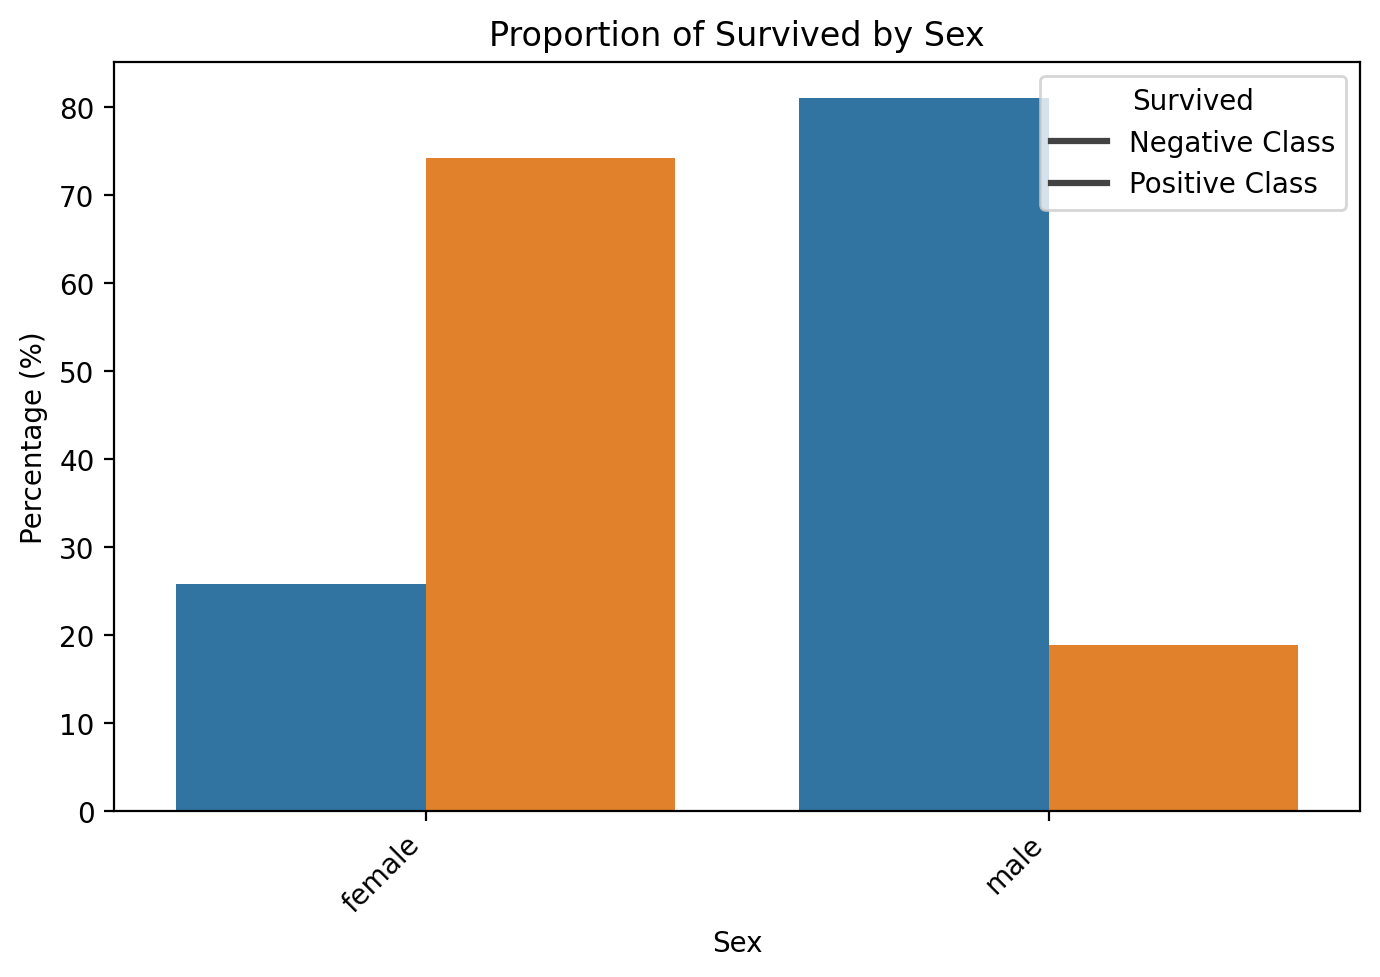

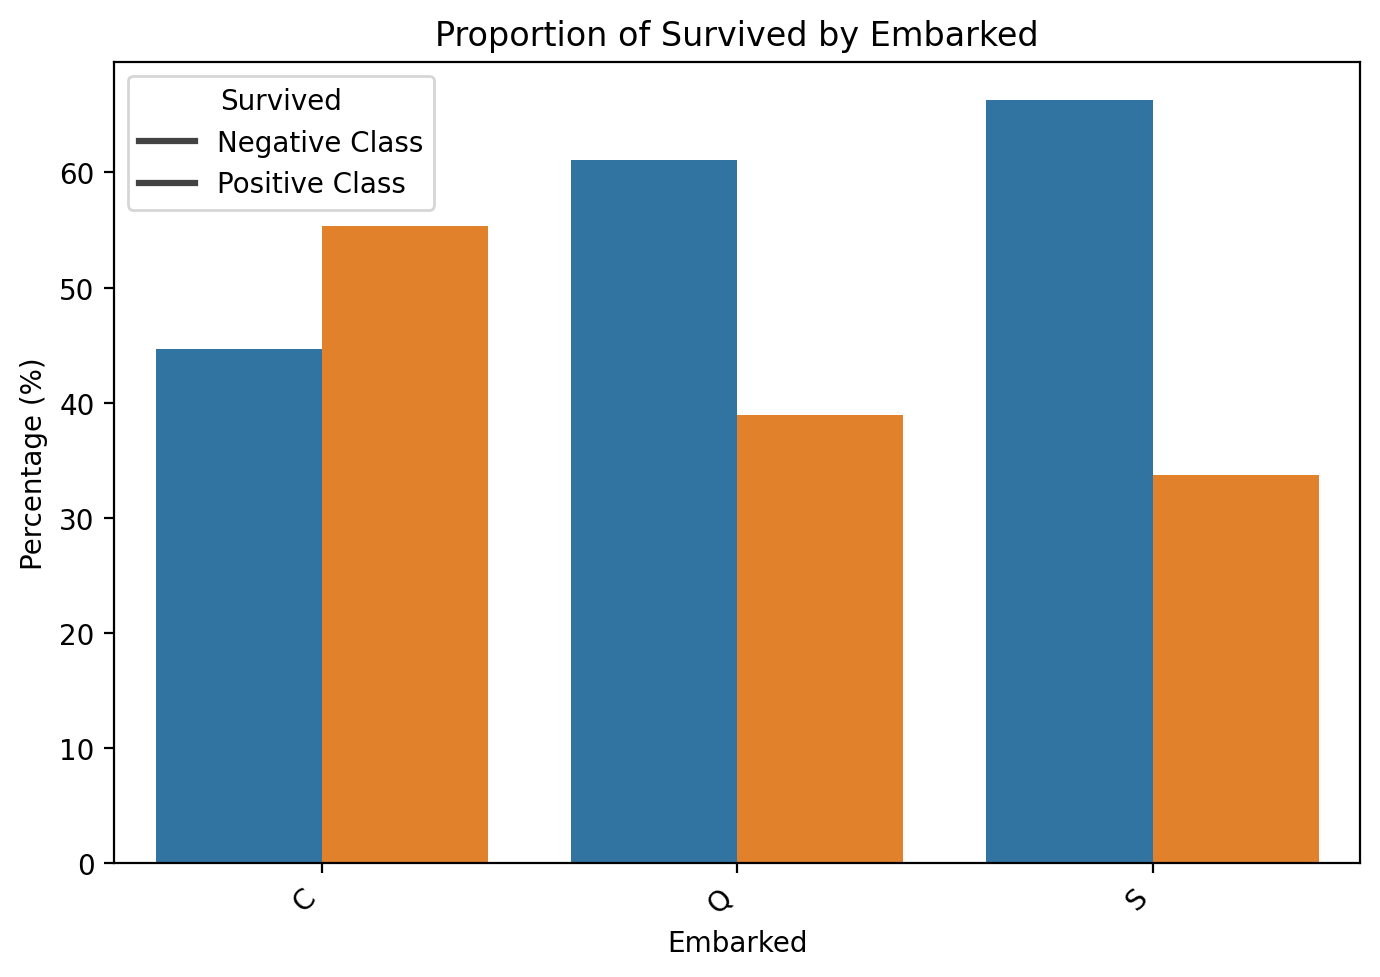

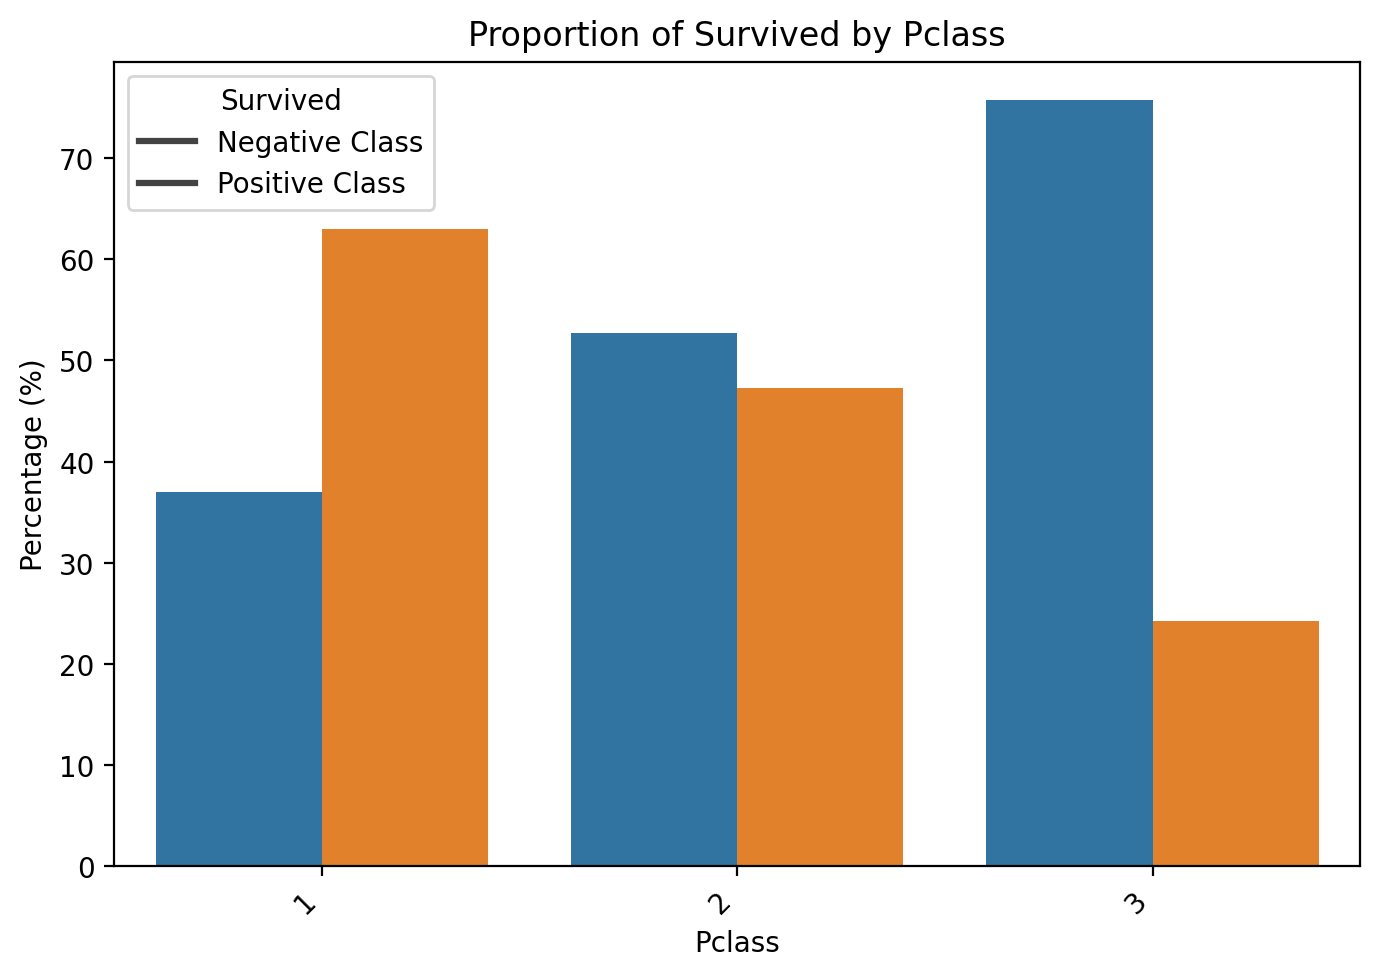

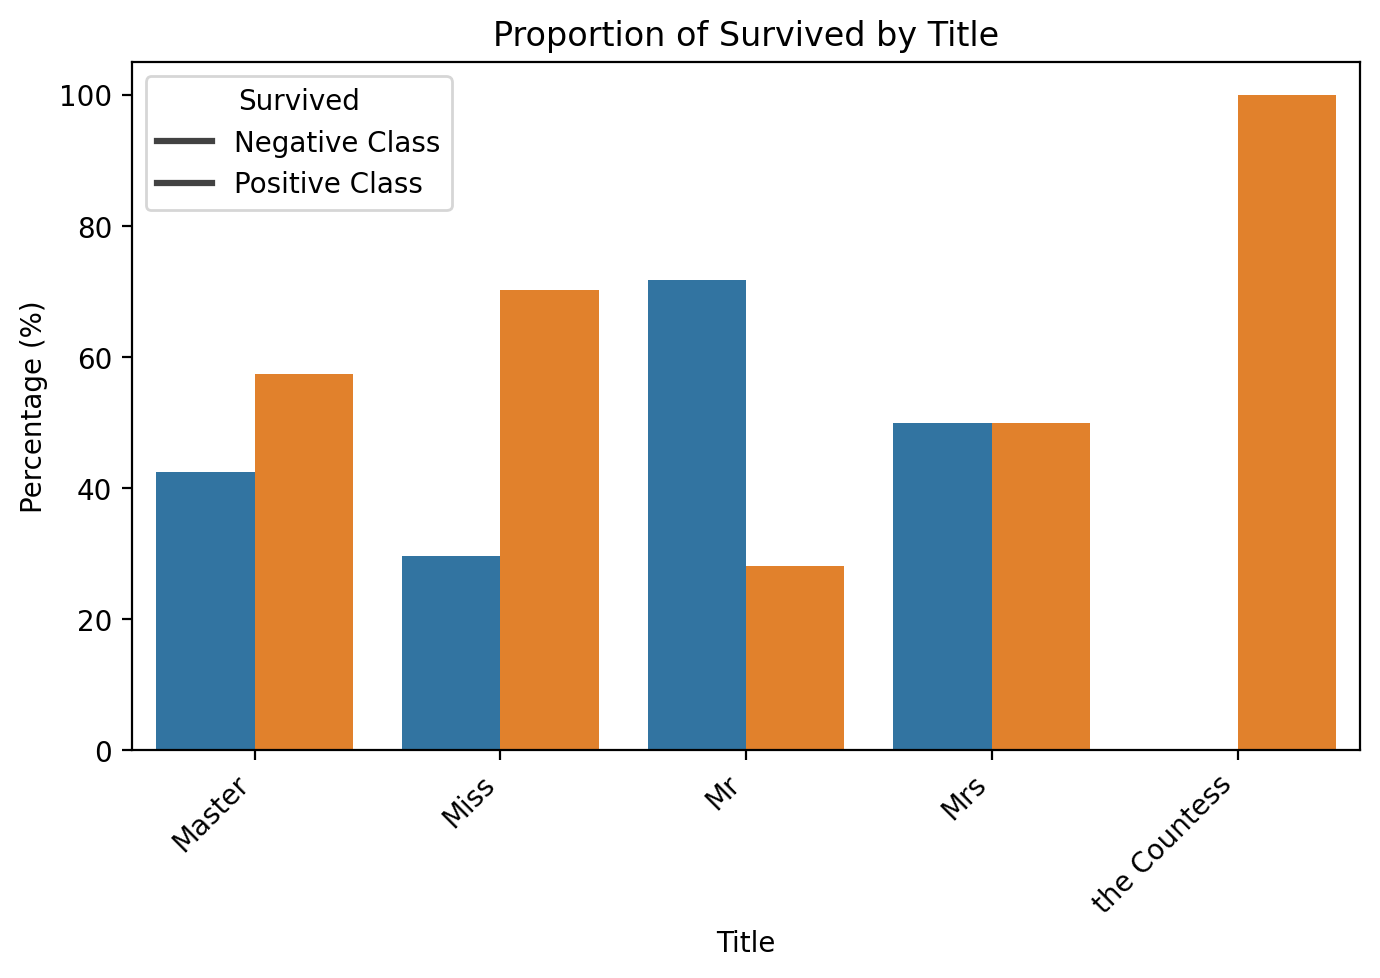

In [55]:
bar_plots_categorical_features(train, categorical_features, target_column)

In [56]:
categorical_features.head()

Sex Embarked  Pclass Title
0    male        S       3    Mr
1  female        C       1    Mr
2  female        S       3  Miss
3  female        S       1    Mr
4    male        S       3    Mr

In [57]:
X = X.drop(columns=['Survived','Sex','Embarked','Pclass','Title'])
X_Pred = X_Pred.drop(columns=['Sex','Embarked','Pclass','Title'])

In [58]:
X.head()

Age  SibSp  Parch     Fare  Family_Size  Sex_female  Sex_male  Embarked_C  \
0  22.0      1      0   7.2500            1       False      True       False   
1  38.0      1      0  71.2833            1        True     False        True   
2  26.0      0      0   7.9250            0        True     False       False   
3  35.0      1      0  53.1000            1        True     False       False   
4  35.0      0      0   8.0500            0       False      True       False   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  Title_Master  \
0       False        True     False     False      True         False   
1       False       False      True     False     False         False   
2       False        True     False     False      True         False   
3       False        True      True     False     False         False   
4       False        True     False     False      True         False   

   Title_Miss  Title_Mr  Title_Mrs  Age_Missing  
0       False      True      False            0  
1       False      True      False            0  
2        True     False      False            0  
3       False      True      False            0  
4       False      True      False            0

In [59]:
X_Pred.head()

Age  SibSp  Parch     Fare  Family_Size  Sex_female  Sex_male  Embarked_C  \
0  34.5      0      0   7.8292            0       False      True       False   
1  47.0      1      0   7.0000            1        True     False       False   
2  62.0      0      0   9.6875            0       False      True       False   
3  27.0      0      0   8.6625            0       False      True       False   
4  22.0      1      1  12.2875            2        True     False       False   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  Title_Master  \
0        True       False     False     False      True         False   
1       False        True     False     False      True         False   
2        True       False     False      True     False         False   
3       False        True     False     False      True         False   
4       False        True     False     False      True         False   

   Title_Miss  Title_Mr  Title_Mrs  Age_Missing  
0       False      True      False            0  
1       False      True      False            0  
2       False      True      False            0  
3       False      True      False            0  
4       False      True      False            0

In [60]:
numerical_features.head()

Age  SibSp  Parch     Fare  Family_Size
0  22.0      1      0   7.2500            1
1  38.0      1      0  71.2833            1
2  26.0      0      0   7.9250            0
3  35.0      1      0  53.1000            1
4  35.0      0      0   8.0500            0

In [61]:
scaler = skl.preprocessing.StandardScaler()
X[['Age','SibSp','Parch','Fare','Family_Size']] = scaler.fit_transform(X[['Age','SibSp','Parch','Fare','Family_Size']])
# X_Pred[['Age','SibSp','Parch','Fare','Family_Size']] = scaler.fit_transform(X_Pred[['Age','SibSp','Parch','Fare','Family_Size']])
X_Pred[['Age','SibSp','Parch','Fare','Family_Size']] = scaler.transform(X_Pred[['Age','SibSp','Parch','Fare','Family_Size']])


In [62]:
X.dtypes

Age             float64
SibSp           float64
Parch           float64
Fare            float64
Family_Size     float64
Sex_female         bool
Sex_male           bool
Embarked_C         bool
Embarked_Q         bool
Embarked_S         bool
Pclass_1           bool
Pclass_2           bool
Pclass_3           bool
Title_Master       bool
Title_Miss         bool
Title_Mr           bool
Title_Mrs          bool
Age_Missing       int64
dtype: object

In [63]:
X_Pred.dtypes

Age             float64
SibSp           float64
Parch           float64
Fare            float64
Family_Size     float64
Sex_female         bool
Sex_male           bool
Embarked_C         bool
Embarked_Q         bool
Embarked_S         bool
Pclass_1           bool
Pclass_2           bool
Pclass_3           bool
Title_Master       bool
Title_Miss         bool
Title_Mr           bool
Title_Mrs          bool
Age_Missing       int64
dtype: object

## Training

In [64]:
# Split data
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
X_train.head()

Age     SibSp     Parch      Fare  Family_Size  Sex_female  \
708 -0.531670 -0.475199 -0.474326  2.404961    -0.561804        True   
240 -0.380182  0.431350 -0.474326 -0.355197     0.057853        True   
382  0.225769 -0.475199 -0.474326 -0.486650    -0.561804       False   
792 -0.380182  6.777195  2.006119  0.754050     5.634773        True   
683 -1.137621  4.057548  2.006119  0.298036     3.775800       False   

     Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
708     False       False       False        True      True     False   
240     False        True       False       False     False     False   
382      True       False       False        True     False     False   
792     False       False       False        True     False     False   
683      True       False       False        True     False     False   

     Pclass_3  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Age_Missing  
708     False         False        True     False      False            0  
240      True         False        True     False      False            1  
382      True         False       False      True      False            0  
792      True         False        True     False      False            1  
683      True         False       False      True      False            0

In [66]:
def optimize_model(trial, model_type):
    params = {}

    if model_type == "Logistic Regression":
        params = {
            "C": trial.suggest_loguniform("C", 0.01, 10),
            "max_iter": trial.suggest_int("max_iter", 100, 1000)
        }
        model = skl.linear_model.LogisticRegression(**params)

    elif model_type == "Decision Tree":
        params = {
            "max_depth": trial.suggest_int("max_depth", 2, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
        }
        model = skl.tree.DecisionTreeClassifier(**params)

    elif model_type == "Random Forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15)
        }
        model = skl.ensemble.RandomForestClassifier(**params)

    elif model_type == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3)
        }
        model = XGBClassifier(**params)

    elif model_type == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "silent" : True
        }
        model = LGBMClassifier(**params)

    elif model_type == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 3, 10),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3)
        }
        model = CatBoostClassifier(**params, verbose=0)

    score = skl.model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return score.mean()


In [67]:
# Optimize each model
optimized_models = {}
for model_name in ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: optimize_model(trial, model_name), n_trials=20)
    optimized_models[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")

[I 2025-05-23 23:41:00,581] A new study created in memory with name: no-name-5b132273-0a68-4aba-9cf7-d125591e402d
[I 2025-05-23 23:41:00,616] Trial 0 finished with value: 0.8016349847335762 and parameters: {'C': 0.03037023063617012, 'max_iter': 504}. Best is trial 0 with value: 0.8016349847335762.
[I 2025-05-23 23:41:00,661] Trial 1 finished with value: 0.8171279424800553 and parameters: {'C': 0.19769167609500102, 'max_iter': 456}. Best is trial 1 with value: 0.8171279424800553.
[I 2025-05-23 23:41:00,696] Trial 2 finished with value: 0.7875898749138186 and parameters: {'C': 0.01502680320234904, 'max_iter': 316}. Best is trial 1 with value: 0.8171279424800553.
[I 2025-05-23 23:41:00,732] Trial 3 finished with value: 0.7960208805279227 and parameters: {'C': 0.018528486739743565, 'max_iter': 129}. Best is trial 1 with value: 0.8171279424800553.
[I 2025-05-23 23:41:00,787] Trial 4 finished with value: 0.8241504973899338 and parameters: {'C': 0.6365555318230993, 'max_iter': 982}. Best is t

Best params for Logistic Regression: {'C': 5.114804082946604, 'max_iter': 136}


[I 2025-05-23 23:41:01,876] Trial 8 finished with value: 0.8171870383137989 and parameters: {'max_depth': 20, 'min_samples_split': 10}. Best is trial 0 with value: 0.8312321481335566.
[I 2025-05-23 23:41:01,904] Trial 9 finished with value: 0.7736038609278045 and parameters: {'max_depth': 18, 'min_samples_split': 2}. Best is trial 0 with value: 0.8312321481335566.
[I 2025-05-23 23:41:01,934] Trial 10 finished with value: 0.7763912144193834 and parameters: {'max_depth': 2, 'min_samples_split': 9}. Best is trial 0 with value: 0.8312321481335566.
[I 2025-05-23 23:41:01,966] Trial 11 finished with value: 0.8101644834039201 and parameters: {'max_depth': 13, 'min_samples_split': 7}. Best is trial 0 with value: 0.8312321481335566.
[I 2025-05-23 23:41:01,997] Trial 12 finished with value: 0.8171574903969271 and parameters: {'max_depth': 8, 'min_samples_split': 6}. Best is trial 0 with value: 0.8312321481335566.
[I 2025-05-23 23:41:02,028] Trial 13 finished with value: 0.8199940904166256 and pa

Best params for Decision Tree: {'max_depth': 4, 'min_samples_split': 4}


[I 2025-05-23 23:41:04,444] Trial 0 finished with value: 0.836865950950458 and parameters: {'n_estimators': 355, 'max_depth': 13}. Best is trial 0 with value: 0.836865950950458.
[I 2025-05-23 23:41:06,151] Trial 1 finished with value: 0.8312419974391805 and parameters: {'n_estimators': 264, 'max_depth': 13}. Best is trial 0 with value: 0.836865950950458.
[I 2025-05-23 23:41:06,601] Trial 2 finished with value: 0.8354673495518565 and parameters: {'n_estimators': 67, 'max_depth': 11}. Best is trial 0 with value: 0.836865950950458.
[I 2025-05-23 23:41:09,041] Trial 3 finished with value: 0.8298433960405791 and parameters: {'n_estimators': 392, 'max_depth': 15}. Best is trial 0 with value: 0.836865950950458.
[I 2025-05-23 23:41:10,457] Trial 4 finished with value: 0.8255983453166552 and parameters: {'n_estimators': 260, 'max_depth': 3}. Best is trial 0 with value: 0.836865950950458.
[I 2025-05-23 23:41:12,086] Trial 5 finished with value: 0.836865950950458 and parameters: {'n_estimators': 

Best params for Random Forest: {'n_estimators': 484, 'max_depth': 7}


[I 2025-05-23 23:41:43,495] Trial 0 finished with value: 0.8241997439180537 and parameters: {'n_estimators': 434, 'max_depth': 3, 'learning_rate': 0.09864531170746195}. Best is trial 0 with value: 0.8241997439180537.
[I 2025-05-23 23:41:44,279] Trial 1 finished with value: 0.8242194425293017 and parameters: {'n_estimators': 204, 'max_depth': 15, 'learning_rate': 0.0611340711144924}. Best is trial 1 with value: 0.8242194425293017.
[I 2025-05-23 23:41:45,524] Trial 2 finished with value: 0.8129616862011229 and parameters: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.05898471593150328}. Best is trial 1 with value: 0.8242194425293017.
[I 2025-05-23 23:41:45,844] Trial 3 finished with value: 0.8452772579533143 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.03438007316636828}. Best is trial 3 with value: 0.8452772579533143.
[I 2025-05-23 23:41:46,228] Trial 4 finished with value: 0.8059489805968681 and parameters: {'n_estimators': 140, 'max_depth': 9, '

Best params for XGBoost: {'n_estimators': 228, 'max_depth': 9, 'learning_rate': 0.01443888727836177}


[I 2025-05-23 23:41:56,896] Trial 0 finished with value: 0.8143898355165963 and parameters: {'n_estimators': 325, 'max_depth': 3, 'learning_rate': 0.18931981753835475}. Best is trial 0 with value: 0.8143898355165963.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 216, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 568, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380282 -> initscore=-0.488353
[LightGBM] [Info] Start training from score -0.488353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-05-23 23:41:57,254] Trial 1 finished with value: 0.8326504481434058 and parameters: {'n_estimators': 309, 'max_depth': 12, 'learning_rate': 0.03316852137193238}. Best is trial 1 with value: 0.8326504481434058.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:41:57,514] Trial 2 finished with value: 0.8452575593420665 and parameters: {'n_estimators': 201, 'max_depth': 14, 'learning_rate': 0.024134967747260407}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:41:57,786] Trial 3 finished with value: 0.8354082537181128 and parameters: {'n_estimators': 127, 'max_depth': 15, 'learning_rate': 0.03868412446396745}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 217, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381371 -> initscore=-0.483734
[LightGBM] [Info] Start training from score -0.483734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-05-23 23:41:58,302] Trial 4 finished with value: 0.8326504481434058 and parameters: {'n_estimators': 409, 'max_depth': 11, 'learning_rate': 0.02257253838351765}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:41:58,820] Trial 5 finished with value: 0.8045208312813946 and parameters: {'n_estimators': 436, 'max_depth': 13, 'learning_rate': 0.28656265646164647}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:41:59,056] Trial 6 finished with value: 0.8368364030335862 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.02723122158641133}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:41:59,191] Trial 7 finished with value: 0.8297941495124596 and parameters: {'n_estimators': 92, 'max_depth': 15, 'learning_rate': 0.01071146543784227}. Best is trial 2 with value: 0.8452575593420665.
[I 2025-05-23 23:41:59,369] Trial 8 finished with value: 0.8368265537279622 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.040604671354852316}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 216, number of negative: 352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 568, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380282 -> initscore=-0.488353
[LightGBM] [Info] Start training from score -0.488353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2025-05-23 23:41:59,543] Trial 9 finished with value: 0.821402541120851 and parameters: {'n_estimators': 121, 'max_depth': 13, 'learning_rate': 0.18545805345075153}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 217, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381371 -> initscore=-0.483734
[LightGBM] [Info] Start training from score -0.483734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-05-23 23:41:59,814] Trial 10 finished with value: 0.8228109918250762 and parameters: {'n_estimators': 223, 'max_depth': 9, 'learning_rate': 0.07878477396145554}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 217, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381371 -> initscore=-0.483734
[LightGBM] [Info] Start training from score -0.483734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2025-05-23 23:42:00,011] Trial 11 finished with value: 0.832620900226534 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.015899155536707746}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 216, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 568, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380282 -> initscore=-0.488353
[LightGBM] [Info] Start training from score -0.488353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-05-23 23:42:00,292] Trial 12 finished with value: 0.8242095932236777 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.0840282281542689}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:42:00,648] Trial 13 finished with value: 0.8354378016349848 and parameters: {'n_estimators': 371, 'max_depth': 6, 'learning_rate': 0.020916681185460365}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:42:00,823] Trial 14 finished with value: 0.8354279523293607 and parameters: {'n_estimators': 183, 'max_depth': 4, 'learning_rate': 0.01143667823897246}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 216, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 568, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380282 -> initscore=-0.488353
[LightGBM] [Info] Start training from score -0.488353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-05-23 23:42:01,541] Trial 15 finished with value: 0.810174332709544 and parameters: {'n_estimators': 489, 'max_depth': 10, 'learning_rate': 0.07100168375143244}. Best is trial 2 with value: 0.8452575593420665.
[I 2025-05-23 23:42:01,644] Trial 16 finished with value: 0.8410420565350144 and parameters: {'n_estimators': 56, 'max_depth': 7, 'learning_rate': 0.026699457951952527}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-23 23:42:01,754] Trial 17 finished with value: 0.8452575593420664 and parameters: {'n_estimators': 68, 'max_depth': 8, 'learning_rate': 0.055584680632509736}. Best is trial 2 with value: 0.8452575593420665.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 217, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381371 -> initscore=-0.483734
[LightGBM] [Info] Start training from score -0.483734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-05-23 23:42:01,968] Trial 18 finished with value: 0.8354575002462326 and parameters: {'n_estimators': 165, 'max_depth': 10, 'learning_rate': 0.05352715517794545}. Best is trial 2 with value: 0.8452575593420665.
[I 2025-05-23 23:42:02,075] Trial 19 finished with value: 0.8424505072392396 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.11024946030182131}. Best is trial 2 with value: 0.8452575593420665.
[I 2025-05-23 23:42:02,076] A new study created in memory with name: no-name-8cbf1d2d-2911-4c96-946f-83f77f1522ea


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 217, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381371 -> initscore=-0.483734
[LightGBM] [Info] Start training from score -0.483734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-05-23 23:42:03,614] Trial 0 finished with value: 0.8368265537279622 and parameters: {'iterations': 235, 'depth': 5, 'learning_rate': 0.01926923403577992}. Best is trial 0 with value: 0.8368265537279622.
[I 2025-05-23 23:42:06,559] Trial 1 finished with value: 0.8410617551462621 and parameters: {'iterations': 398, 'depth': 6, 'learning_rate': 0.017973886854515658}. Best is trial 1 with value: 0.8410617551462621.
[I 2025-05-23 23:42:10,949] Trial 2 finished with value: 0.8017433270954397 and parameters: {'iterations': 953, 'depth': 4, 'learning_rate': 0.21474630466486205}. Best is trial 1 with value: 0.8410617551462621.
[I 2025-05-23 23:42:14,767] Trial 3 finished with value: 0.801703929872944 and parameters: {'iterations': 902, 'depth': 3, 'learning_rate': 0.21744906189292368}. Best is trial 1 with value: 0.8410617551462621.
[I 2025-05-23 23:42:21,653] Trial 4 finished with value: 0.8185954890180241 and parameters: {'iterations': 899, 'depth': 6, 'learning_rate': 0.0460364494846

Best params for CatBoost: {'iterations': 495, 'depth': 9, 'learning_rate': 0.010849179604236888}


In [68]:
models = {
    "Logistic Regression": skl.linear_model.LogisticRegression(**optimized_models["Logistic Regression"]),
    "Decision Tree": skl.tree.DecisionTreeClassifier(**optimized_models["Decision Tree"]),
    "Random Forest": skl.ensemble.RandomForestClassifier(**optimized_models["Random Forest"]),
    "XGBoost": XGBClassifier(**optimized_models["XGBoost"]),
    "LightGBM": LGBMClassifier(**optimized_models["LightGBM"], verbose=-1),
    "CatBoost": CatBoostClassifier(**optimized_models["CatBoost"], verbose=0)
}

In [69]:
# Train & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = skl.metrics.accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.8315
Decision Tree Accuracy: 0.8202
Random Forest Accuracy: 0.7921
XGBoost Accuracy: 0.7921
LightGBM Accuracy: 0.8090
CatBoost Accuracy: 0.7978


In [70]:
# # Select best-performing model (replace with actual best model)
# best_model = models["XGBoost"]  # Example

# # Fit SHAP explainer
# explainer = shap.Explainer(best_model, X_train)
# shap_values = explainer(X_test)

# # Plot feature importance
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [71]:
X_Pred.head()

Age     SibSp     Parch      Fare  Family_Size  Sex_female  Sex_male  \
0  0.401768 -0.499470 -0.400248 -0.497811    -0.553443       False      True   
1  1.371615  0.616992 -0.400248 -0.512660     0.105643        True     False   
2  2.535433 -0.499470 -0.400248 -0.464532    -0.553443       False      True   
3 -0.180141 -0.499470 -0.400248 -0.482888    -0.553443       False      True   
4 -0.568080  0.616992  0.619896 -0.417971     0.764728        True     False   

   Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  \
0       False        True       False     False     False      True   
1       False       False        True     False     False      True   
2       False        True       False     False      True     False   
3       False       False        True     False     False      True   
4       False       False        True     False     False      True   

   Title_Master  Title_Miss  Title_Mr  Title_Mrs  Age_Missing  
0         False       False      True      False            0  
1         False       False      True      False            0  
2         False       False      True      False            0  
3         False       False      True      False            0  
4         False       False      True      False            0

In [75]:
X_Pred['Fare'].fillna(X_Pred['Fare'].median(), inplace=True)

In [76]:
X_Pred.isna().sum()

Age             0
SibSp           0
Parch           0
Fare            0
Family_Size     0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Age_Missing     0
dtype: int64

In [78]:
X_Pred_Passenger.head()

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

In [79]:
# Loop through all trained models and save predictions separately
for model_name, model in models.items():
    predictions = model.predict(X_Pred)  # Generate predictions using X_Pred

    # Create a submission DataFrame with required format
    submission_df = pd.DataFrame({"PassengerId": X_Pred_Passenger, "Survived": predictions})

    # Save each model’s predictions as a separate CSV file
    filename = f"{model_name}_submission.csv"
    submission_df.to_csv(filename, index=False)
    
    print(f"Saved: {filename}")

Saved: Logistic Regression_submission.csv
Saved: Decision Tree_submission.csv
Saved: Random Forest_submission.csv
Saved: XGBoost_submission.csv
Saved: LightGBM_submission.csv
Saved: CatBoost_submission.csv
